In [27]:
# Core imports
import datetime, time, requests

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
#from mpl_toolkits.basemap import Basemap

# Rendering imports
import imageio

# Supress Warnings
plt.rcParam.update({'figure.max_open_warning':0})

AttributeError: module 'matplotlib.pyplot' has no attribute 'rcParam'

In [2]:
plottedImage = []
imageFilenames = []

In [3]:
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'

covidDataset = pd.read_csv(url)
print(covidDataset.head())

         Date      Country  Confirmed  Recovered  Deaths
0  2020-01-22  Afghanistan          0          0       0
1  2020-01-22      Albania          0          0       0
2  2020-01-22      Algeria          0          0       0
3  2020-01-22      Andorra          0          0       0
4  2020-01-22       Angola          0          0       0


In [4]:
covidDataset['Date'] = pd.to_datetime(covidDataset['Date'])
covidDataset = covidDataset.sort_values('Date', ascending=True)

In [5]:
covidDataset['Country'] = covidDataset['Country'].fillna('No_Country')
print('Data cleaning - Blank Country Fields -> No Country: \n', covidDataset.tail())

Data cleaning - Blank Country Fields -> No Country: 
             Date   Country  Confirmed  Recovered  Deaths
38416 2020-08-13    Gambia       1556        267      43
38417 2020-08-13   Georgia       1283       1068      17
38418 2020-08-13   Germany     222281     199654    9217
38409 2020-08-13   Estonia       2174       1975      63
38539 2020-08-13  Zimbabwe       4990       1927     128


In [6]:
nanCount = len(covidDataset) - covidDataset.count()
print('Data cleaning - Blank Fields count: \n', nanCount)

Data cleaning - Blank Fields count: 
 Date         0
Country      0
Confirmed    0
Recovered    0
Deaths       0
dtype: int64


In [7]:
countriesList = list(set(covidDataset['Country']))
print('Number of Countries in dataset:', str(len(countriesList)))

Number of Countries in dataset: 188


In [62]:
# Fetch the coordinates for each country

In [8]:
def getCoordLimits(country,
                coordLimitsFormat='center'):
    # Cordinates obtained from the OpenstreetmapAPI
    url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?q=',
                             country,
                             '&format=json&polygon=0')
    # send out request
    response = requests.get(url).json()[0]

    # parse response to list
    if coordLimitsFormat == 'boundingbox':
        lst = response[coordLimitsFormat]
        coordLimits = [float(i) for i in lst]
    if coordLimitsFormat == 'center':
        lst = [response.get(key) for key in ['lon', 'lat']]
        coordLimits = [float(i) for i in lst]

    return coordLimits

In [9]:
lonLimits = []
latLimits = []
countryCnt = len(countriesList)
processed = 0
for country in countriesList:
    if processed % 10 == 0:
        print('Countries remaining for processing coordinates: ', countryCnt - processed)
    coordinates = [None, None]
    
    try:
        coordinates = getCoordLimits(country, coordLimitsFormat='center')
    except:
        print('Could not find:', country)

    lonLimits.append(coordinates[0])
    latLimits.append(coordinates[1])

    processed += 1

# Append coordinate limits into dataset
latitudesList = []
longitudeList = []
for i, r in covidDataset.iterrows():
    country = r['Country']
    countryIndex = countriesList.index(country)
    latitudesList.append(latLimits[countryIndex])
    longitudeList.append(lonLimits[countryIndex])

covidDataset['Longitude'] = longitudeList
covidDataset['Latitude'] = latitudesList

Countries remaining for processing coordinates:  188
Countries remaining for processing coordinates:  178
Countries remaining for processing coordinates:  168
Countries remaining for processing coordinates:  158
Countries remaining for processing coordinates:  148
Countries remaining for processing coordinates:  138
Countries remaining for processing coordinates:  128
Countries remaining for processing coordinates:  118
Countries remaining for processing coordinates:  108
Countries remaining for processing coordinates:  98
Countries remaining for processing coordinates:  88
Countries remaining for processing coordinates:  78
Countries remaining for processing coordinates:  68
Countries remaining for processing coordinates:  58
Countries remaining for processing coordinates:  48
Countries remaining for processing coordinates:  38
Countries remaining for processing coordinates:  28
Countries remaining for processing coordinates:  18
Countries remaining for processing coordinates:  8


In [10]:
# Creating a world map using basemap and plotting Covid Data
def worldHeatMapPlot(dataToPlot, date, fileName=''):
    plt.figure(figsize=(16, 8))

    # Creating World map
    m = Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80)
    m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")

    confirmedCases = np.sum(dataToPlot['Confirmed'])

    # Plotting data on map
    m.scatter(dataToPlot['Longitude'],
              dataToPlot['Latitude'],
              s=dataToPlot['Confirmed'],
              alpha=0.4,
              c=dataToPlot['labels_enc'],
              cmap="Set1")

    plt.title( ' Confirmed Covid-19 Cases on ' + str(date) + ' : ' +
              str(int(confirmedCases)), fontsize=32)
    
    plt.text(0.5, 0.5, '(circles not to scale)', horizontalalignment = 'right', verticalalignment = 'bottom')

    if fileName != '':
        plt.savefig(fileName)

    # plt.show()

In [11]:
# Creating a unique color code for each country
covidDataset['labels_enc'] = pd.factorize(covidDataset['Country'])[0]

In [12]:
## Plotting live world heat map
# Sort the dataset based on dates
dates = sorted(list(set(covidDataset['Date'])))

processedImages = 0
for date in dates:
    dataToPlot = covidDataset[covidDataset['Date'] <= date]

    dataToPlot = dataToPlot[['Country', 'labels_enc', 'Confirmed',
                                           'Deaths', 'Recovered',
                                           'Longitude', 'Latitude']]

    
    # Aggregate virus information and group them by country
    dataToPlot = dataToPlot.groupby(['Country', 'labels_enc']).agg({'Confirmed': 'last',
                                                                                  'Deaths': 'last',
                                                                                  'Recovered': 'last',
                                                                                  'Longitude': 'mean',
                                                                                  'Latitude': 'mean'}).reset_index()

    dataToPlot = dataToPlot.groupby(['Country', 'labels_enc']).agg({'Confirmed': 'sum',
                                                                                  'Deaths': 'sum',
                                                                                  'Recovered': 'sum',
                                                                                  'Longitude': 'mean',
                                                                                  'Latitude': 'mean'}).reset_index()

    # Plot the data on world map and save output to a file (.png)    
    imageName = 'animation/worldHeatMap/plot_' + str(processedImages) + '.png'
    imageFilenames.append(imageName)
    worldHeatMapPlot(dataToPlot, str(date)[0:10], imageName)

    processedImages += 1

NameError: name 'Basemap' is not defined

<Figure size 1152x576 with 0 Axes>

In [14]:
# Creating gif animation for the world heat map plot
def createGif(imageFilenames, gifLocation):
    plottedImage = []
    for filename in imageFilenames:
        plottedImage.append(imageio.imread(filename))
    imageio.mimsave(gifLocation, plottedImage)
    
createGif(imageFilenames, 'animation/covidWorldHeatMap.gif')

print("Plotting of the world heat map is succesfully completed. Please find the covidWorldHeatMap.gif inside the 'animation' folder")

Plotting of the world heat map is succesfully completed. Please find the covidWorldHeatMap.gif inside the 'animation' folder


In [15]:
## Live Time Series Line chart Plotting
# Extracting confirmed, recovered, death from dataset
confirmed = covidDataset.groupby('Date').sum()['Confirmed'].reset_index()
print('Before\n: ', confirmed.head(3))
confirmed = confirmed.set_index('Date')
print('After\n: ', confirmed.head(3))
deaths = covidDataset.groupby('Date').sum()['Deaths'].reset_index()
deaths = deaths.set_index('Date')
recovered = covidDataset.groupby('Date').sum()['Recovered'].reset_index()
recovered = recovered.set_index('Date')
imageFilenames = []
processedImages = 0


Before
:          Date  Confirmed
0 2020-01-22        555
1 2020-01-23        654
2 2020-01-24        941
After
:              Confirmed
Date                 
2020-01-22        555
2020-01-23        654
2020-01-24        941


C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interf

<Figure size 1152x576 with 0 Axes>

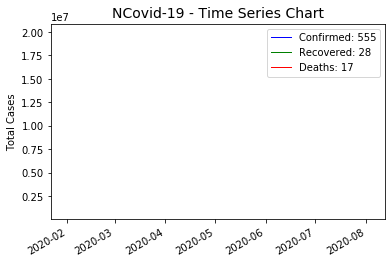

<Figure size 1152x576 with 0 Axes>

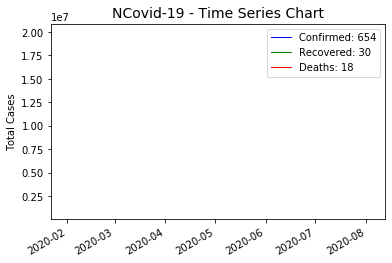

<Figure size 1152x576 with 0 Axes>

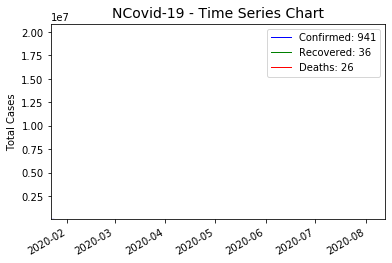

<Figure size 1152x576 with 0 Axes>

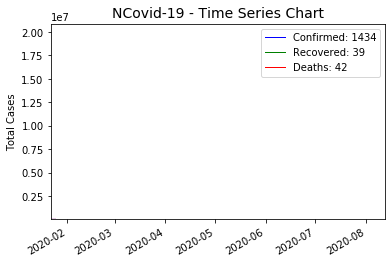

<Figure size 1152x576 with 0 Axes>

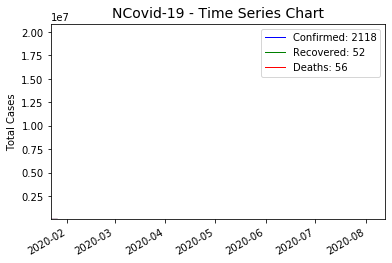

<Figure size 1152x576 with 0 Axes>

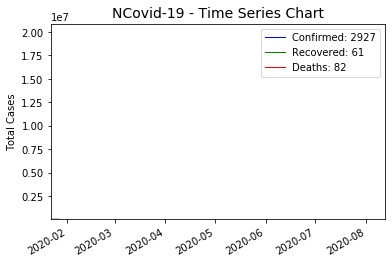

<Figure size 1152x576 with 0 Axes>

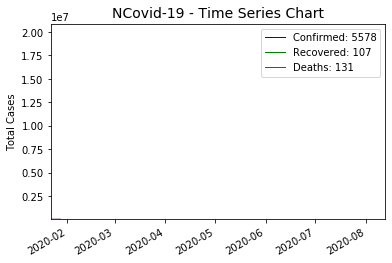

<Figure size 1152x576 with 0 Axes>

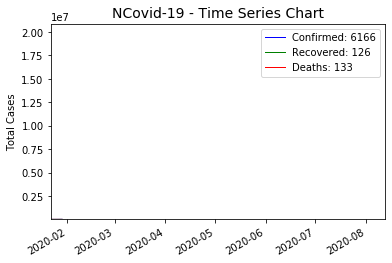

<Figure size 1152x576 with 0 Axes>

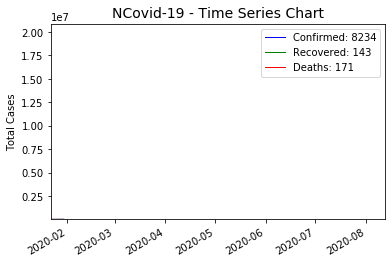

<Figure size 1152x576 with 0 Axes>

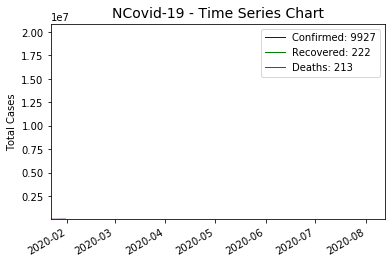

<Figure size 1152x576 with 0 Axes>

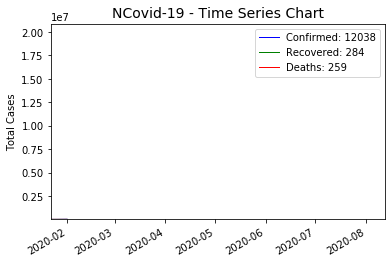

<Figure size 1152x576 with 0 Axes>

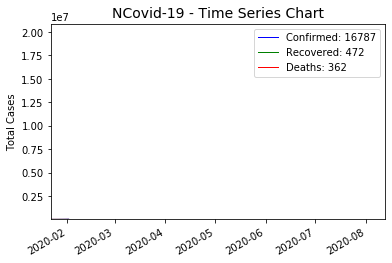

<Figure size 1152x576 with 0 Axes>

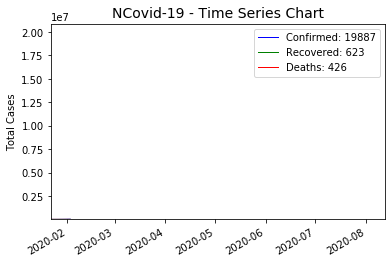

<Figure size 1152x576 with 0 Axes>

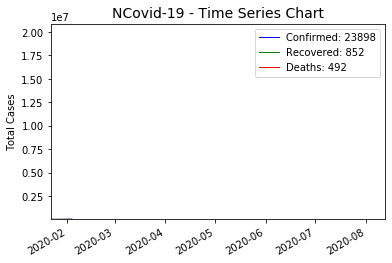

<Figure size 1152x576 with 0 Axes>

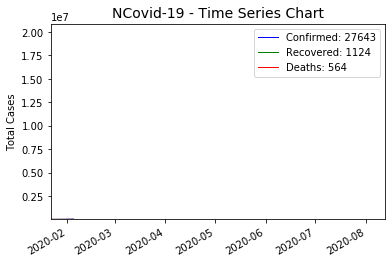

<Figure size 1152x576 with 0 Axes>

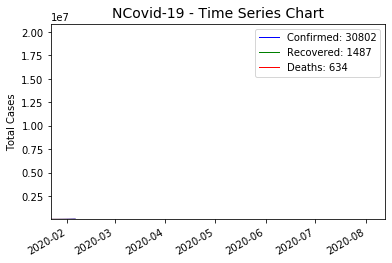

<Figure size 1152x576 with 0 Axes>

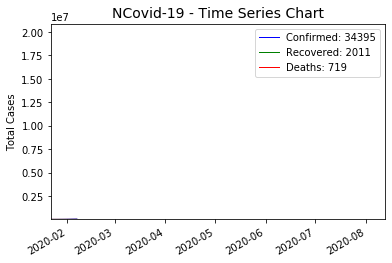

<Figure size 1152x576 with 0 Axes>

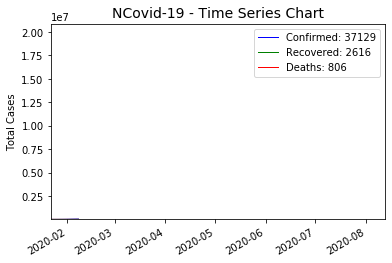

<Figure size 1152x576 with 0 Axes>

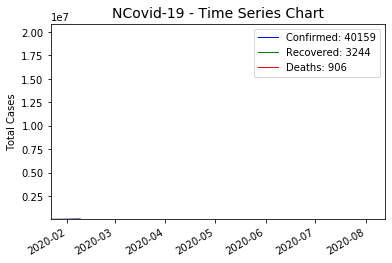

<Figure size 1152x576 with 0 Axes>

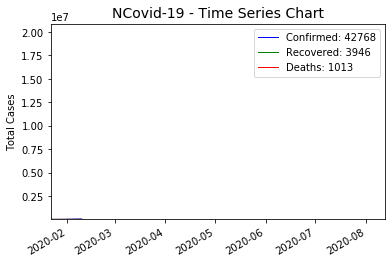

<Figure size 1152x576 with 0 Axes>

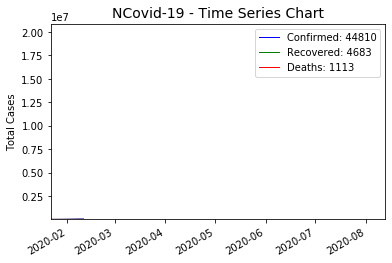

<Figure size 1152x576 with 0 Axes>

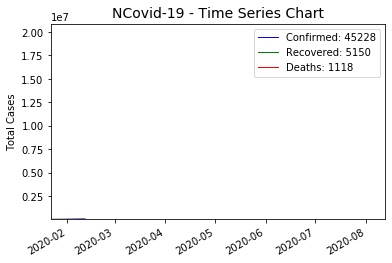

<Figure size 1152x576 with 0 Axes>

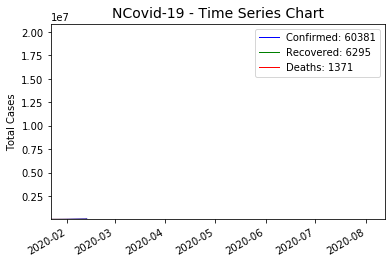

<Figure size 1152x576 with 0 Axes>

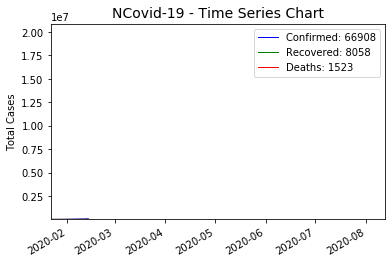

<Figure size 1152x576 with 0 Axes>

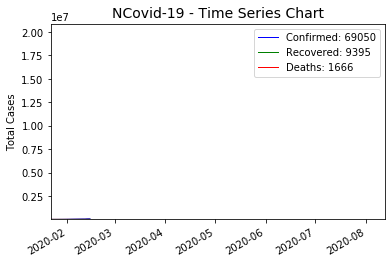

<Figure size 1152x576 with 0 Axes>

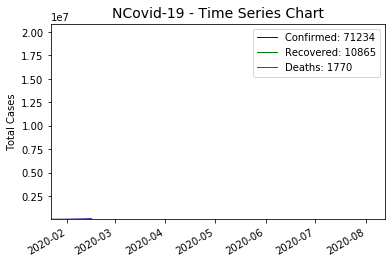

<Figure size 1152x576 with 0 Axes>

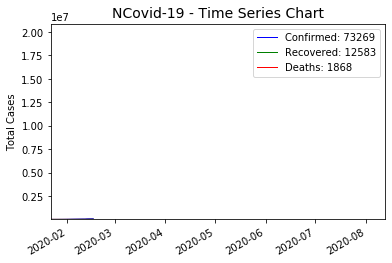

<Figure size 1152x576 with 0 Axes>

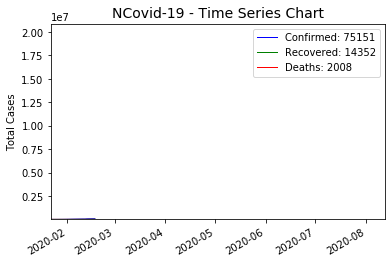

<Figure size 1152x576 with 0 Axes>

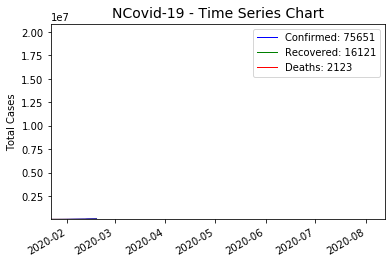

<Figure size 1152x576 with 0 Axes>

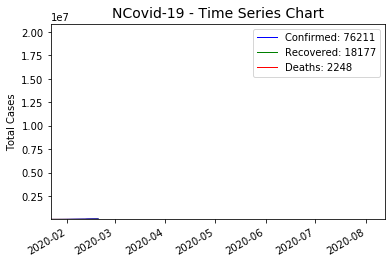

<Figure size 1152x576 with 0 Axes>

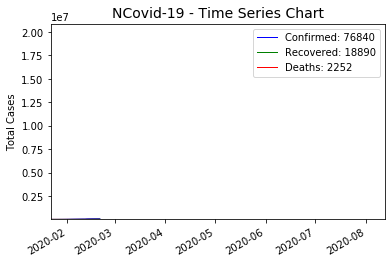

<Figure size 1152x576 with 0 Axes>

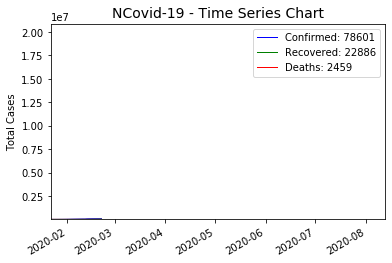

<Figure size 1152x576 with 0 Axes>

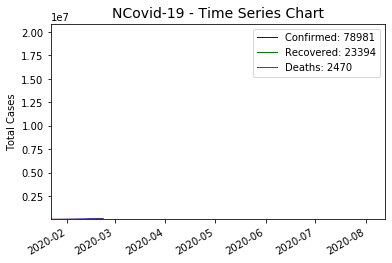

<Figure size 1152x576 with 0 Axes>

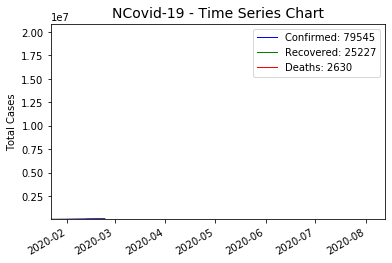

<Figure size 1152x576 with 0 Axes>

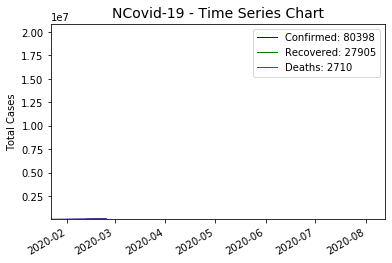

<Figure size 1152x576 with 0 Axes>

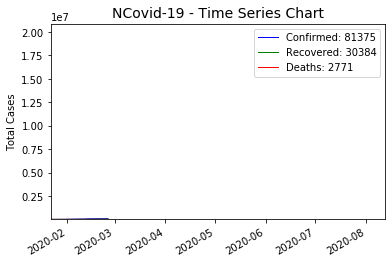

<Figure size 1152x576 with 0 Axes>

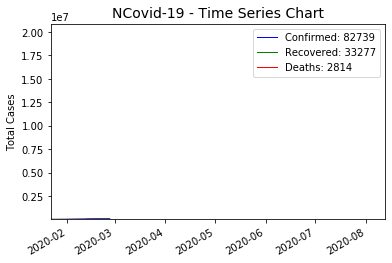

<Figure size 1152x576 with 0 Axes>

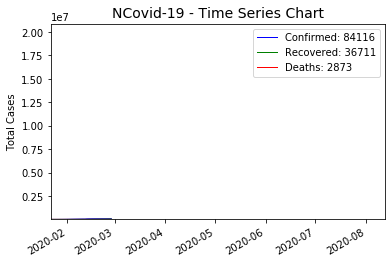

<Figure size 1152x576 with 0 Axes>

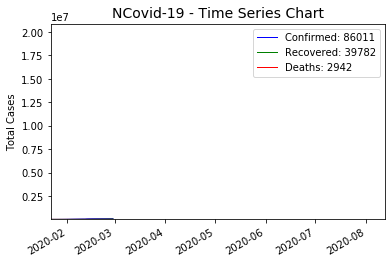

<Figure size 1152x576 with 0 Axes>

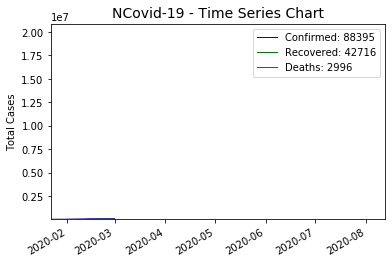

<Figure size 1152x576 with 0 Axes>

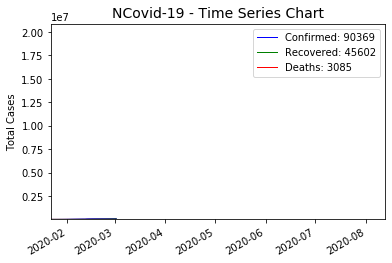

<Figure size 1152x576 with 0 Axes>

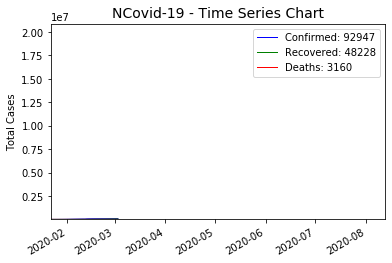

<Figure size 1152x576 with 0 Axes>

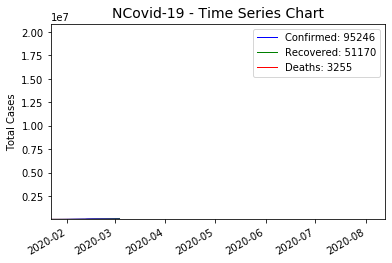

<Figure size 1152x576 with 0 Axes>

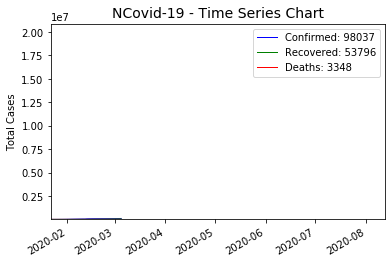

<Figure size 1152x576 with 0 Axes>

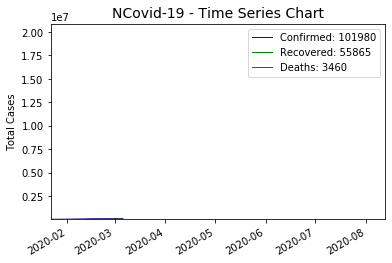

<Figure size 1152x576 with 0 Axes>

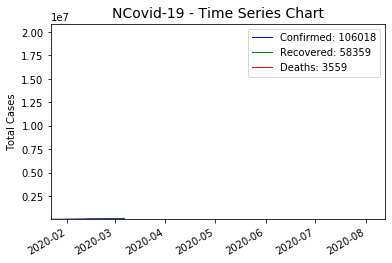

<Figure size 1152x576 with 0 Axes>

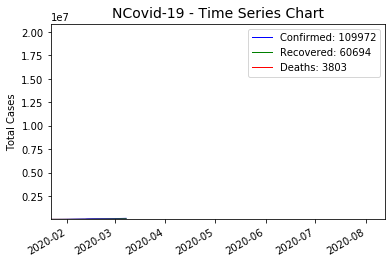

<Figure size 1152x576 with 0 Axes>

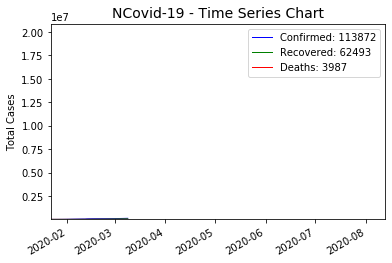

<Figure size 1152x576 with 0 Axes>

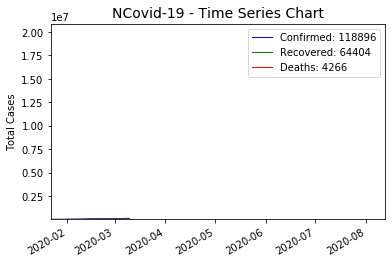

<Figure size 1152x576 with 0 Axes>

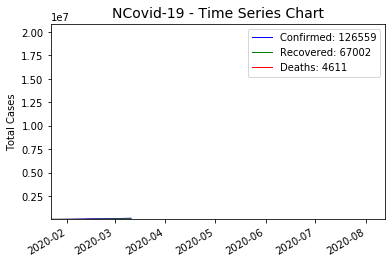

<Figure size 1152x576 with 0 Axes>

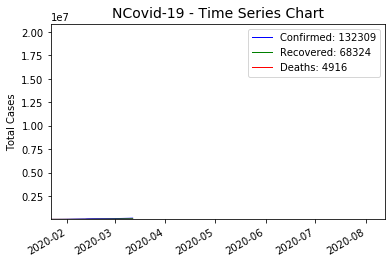

<Figure size 1152x576 with 0 Axes>

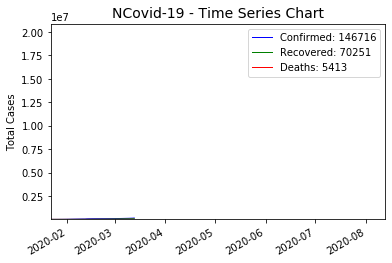

<Figure size 1152x576 with 0 Axes>

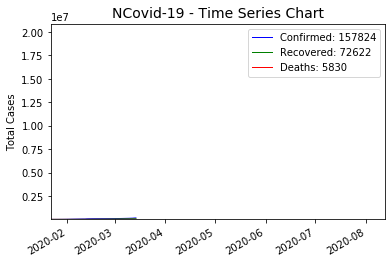

<Figure size 1152x576 with 0 Axes>

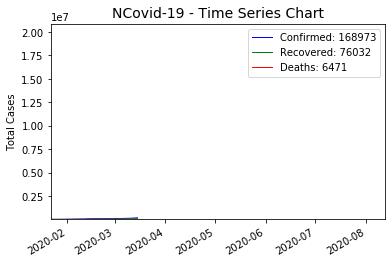

<Figure size 1152x576 with 0 Axes>

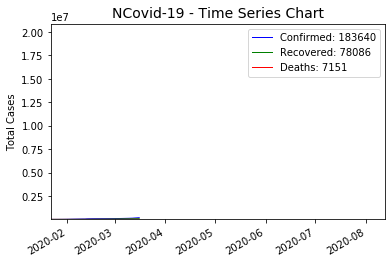

<Figure size 1152x576 with 0 Axes>

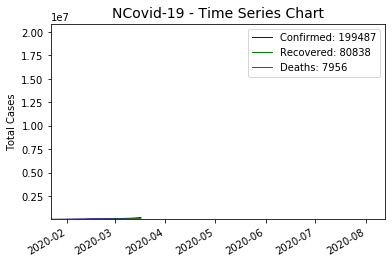

<Figure size 1152x576 with 0 Axes>

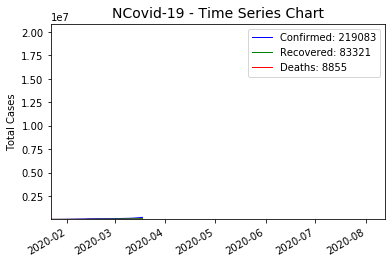

<Figure size 1152x576 with 0 Axes>

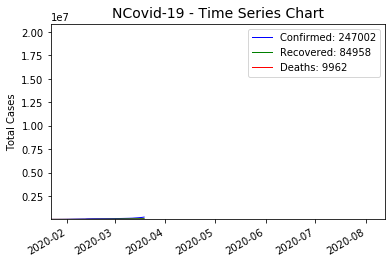

<Figure size 1152x576 with 0 Axes>

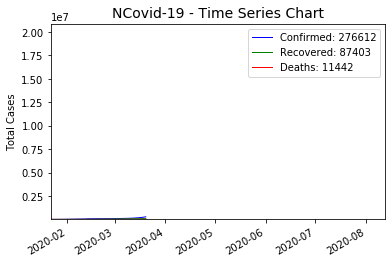

<Figure size 1152x576 with 0 Axes>

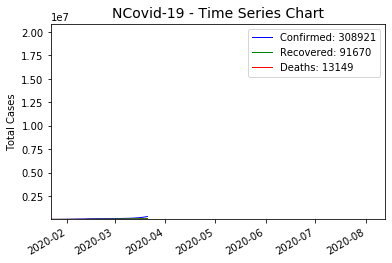

<Figure size 1152x576 with 0 Axes>

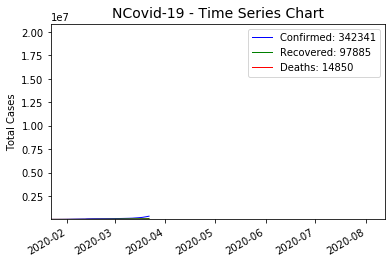

<Figure size 1152x576 with 0 Axes>

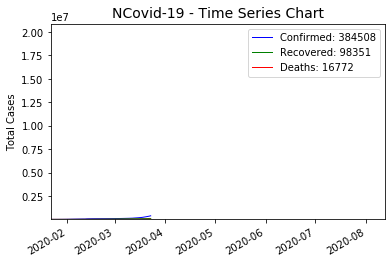

<Figure size 1152x576 with 0 Axes>

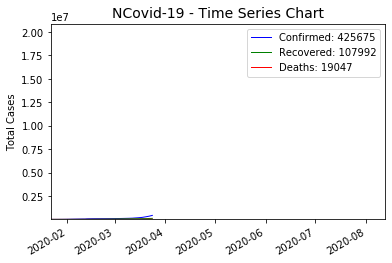

<Figure size 1152x576 with 0 Axes>

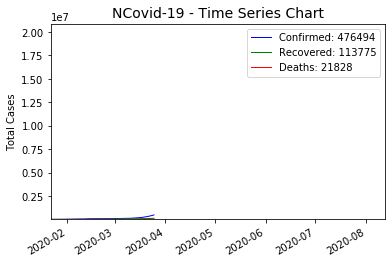

<Figure size 1152x576 with 0 Axes>

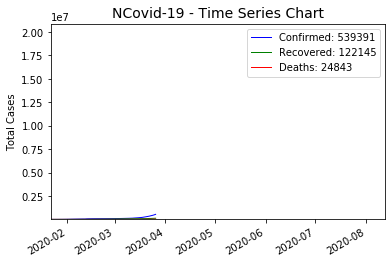

<Figure size 1152x576 with 0 Axes>

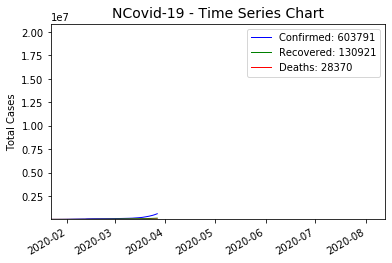

<Figure size 1152x576 with 0 Axes>

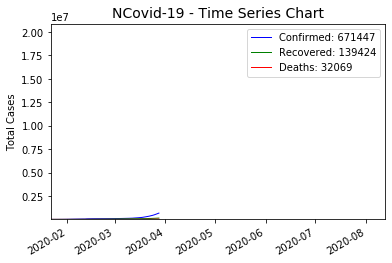

<Figure size 1152x576 with 0 Axes>

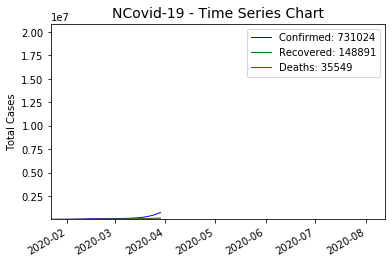

<Figure size 1152x576 with 0 Axes>

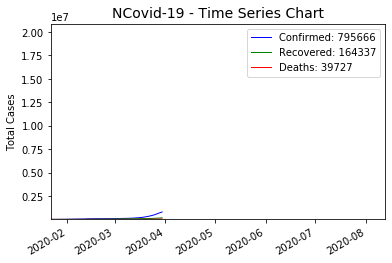

<Figure size 1152x576 with 0 Axes>

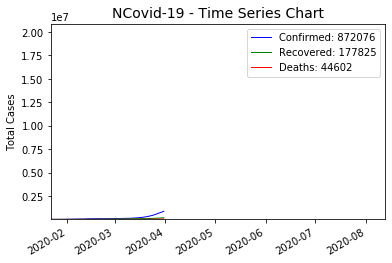

<Figure size 1152x576 with 0 Axes>

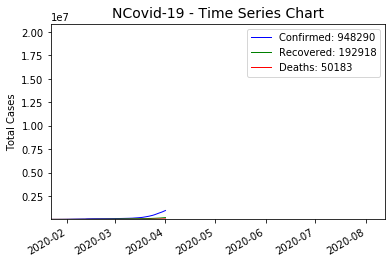

<Figure size 1152x576 with 0 Axes>

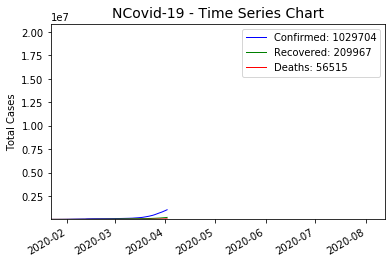

<Figure size 1152x576 with 0 Axes>

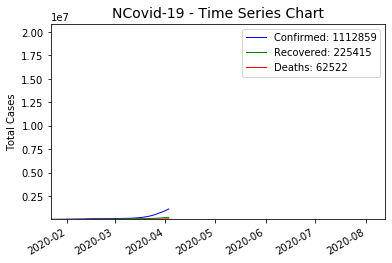

<Figure size 1152x576 with 0 Axes>

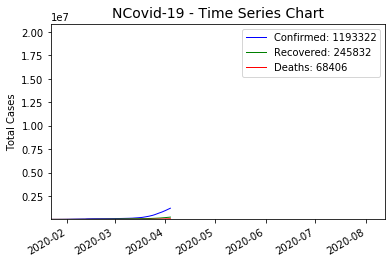

<Figure size 1152x576 with 0 Axes>

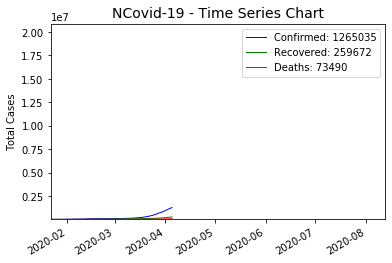

<Figure size 1152x576 with 0 Axes>

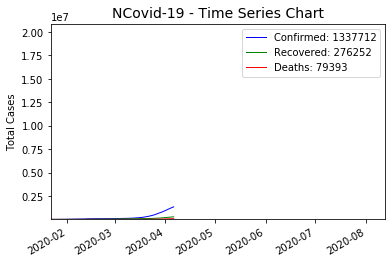

<Figure size 1152x576 with 0 Axes>

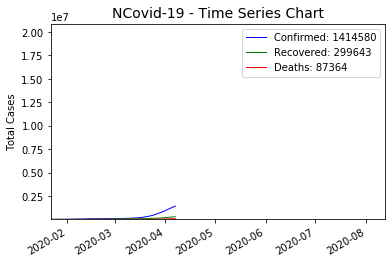

<Figure size 1152x576 with 0 Axes>

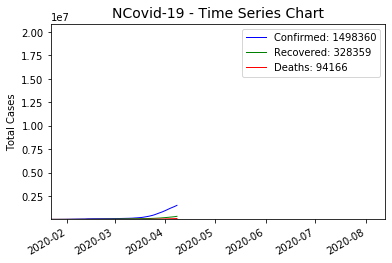

<Figure size 1152x576 with 0 Axes>

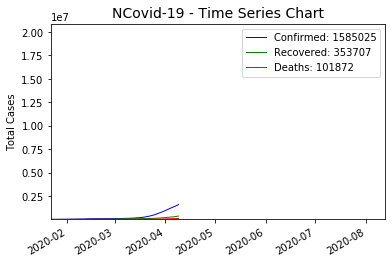

<Figure size 1152x576 with 0 Axes>

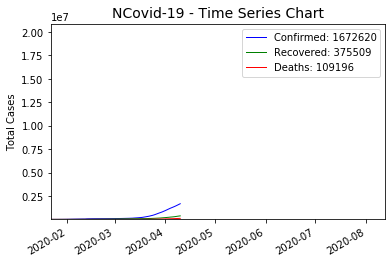

<Figure size 1152x576 with 0 Axes>

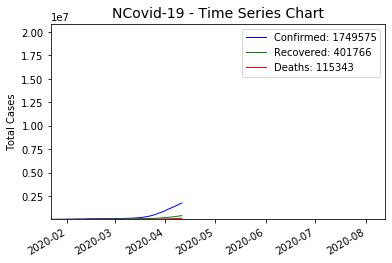

<Figure size 1152x576 with 0 Axes>

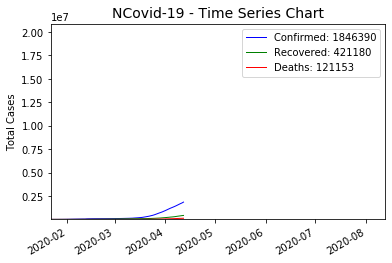

<Figure size 1152x576 with 0 Axes>

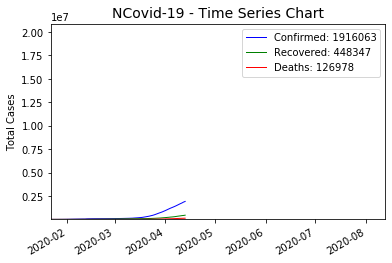

<Figure size 1152x576 with 0 Axes>

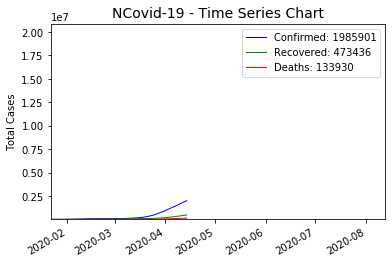

<Figure size 1152x576 with 0 Axes>

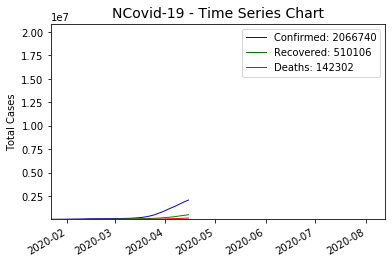

<Figure size 1152x576 with 0 Axes>

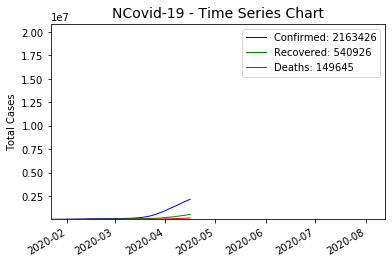

<Figure size 1152x576 with 0 Axes>

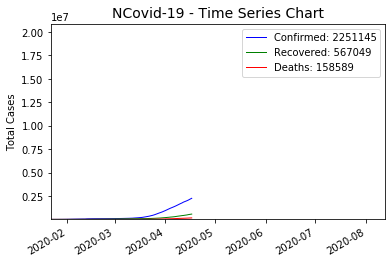

<Figure size 1152x576 with 0 Axes>

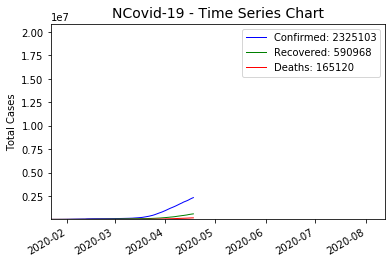

<Figure size 1152x576 with 0 Axes>

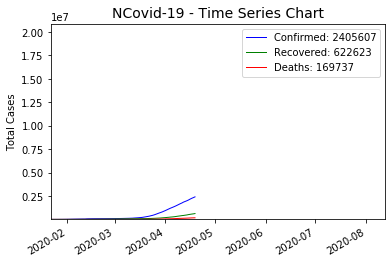

<Figure size 1152x576 with 0 Axes>

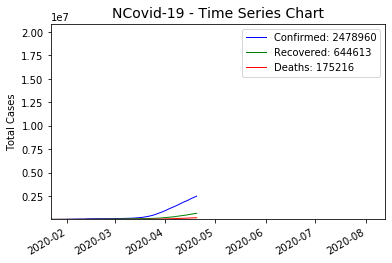

<Figure size 1152x576 with 0 Axes>

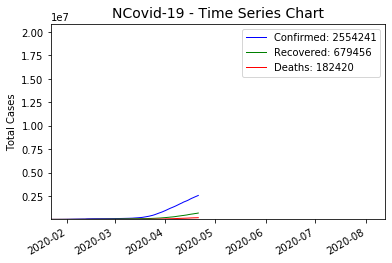

<Figure size 1152x576 with 0 Axes>

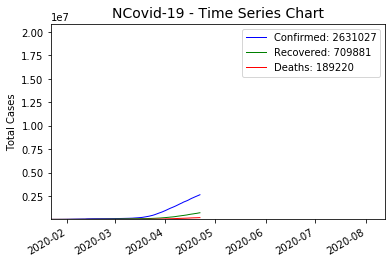

<Figure size 1152x576 with 0 Axes>

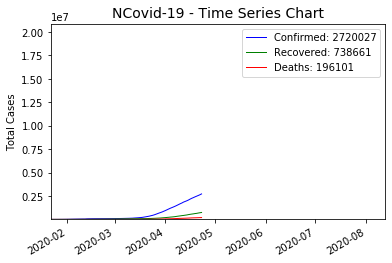

<Figure size 1152x576 with 0 Axes>

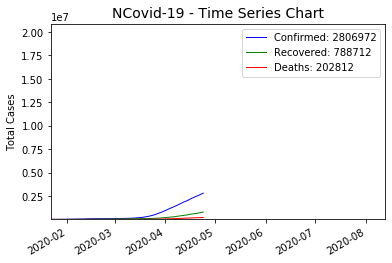

<Figure size 1152x576 with 0 Axes>

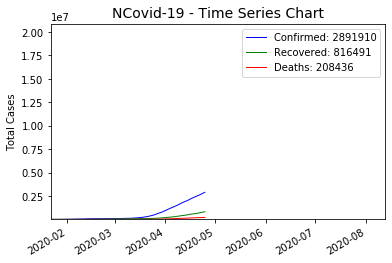

<Figure size 1152x576 with 0 Axes>

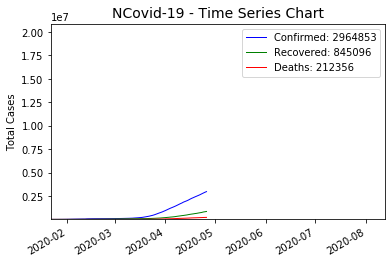

<Figure size 1152x576 with 0 Axes>

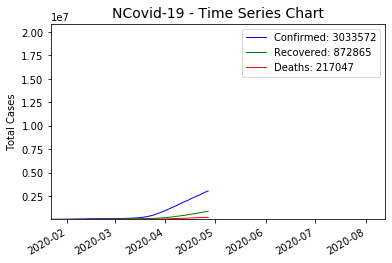

<Figure size 1152x576 with 0 Axes>

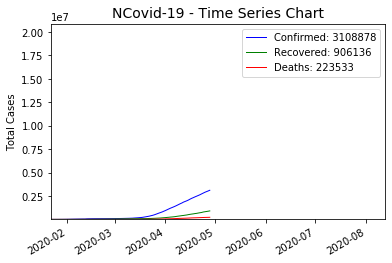

<Figure size 1152x576 with 0 Axes>

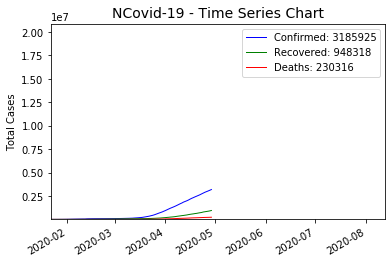

<Figure size 1152x576 with 0 Axes>

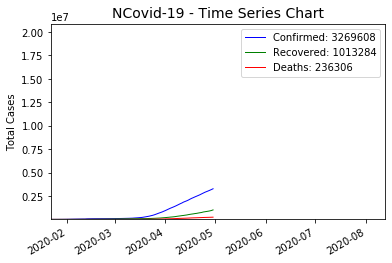

<Figure size 1152x576 with 0 Axes>

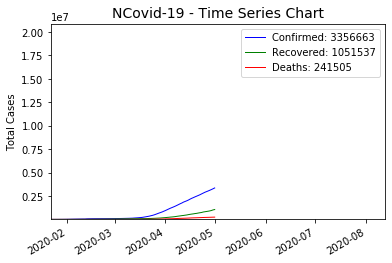

<Figure size 1152x576 with 0 Axes>

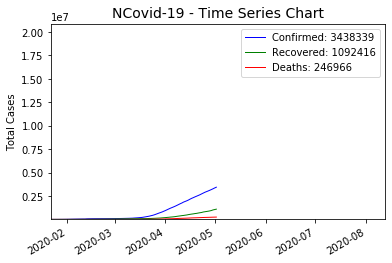

<Figure size 1152x576 with 0 Axes>

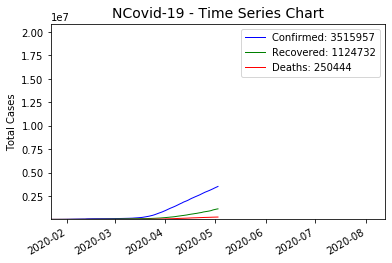

<Figure size 1152x576 with 0 Axes>

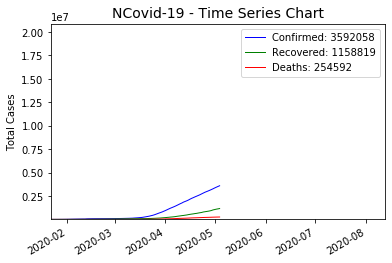

<Figure size 1152x576 with 0 Axes>

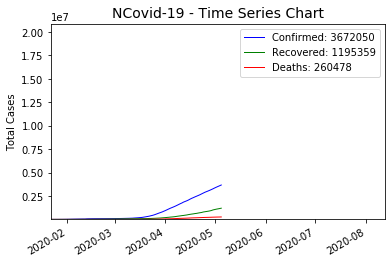

<Figure size 1152x576 with 0 Axes>

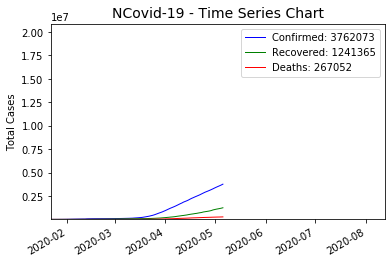

<Figure size 1152x576 with 0 Axes>

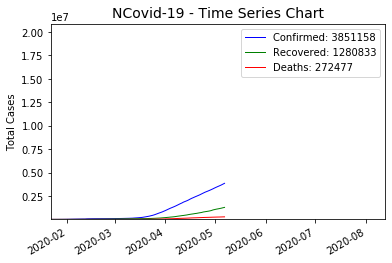

<Figure size 1152x576 with 0 Axes>

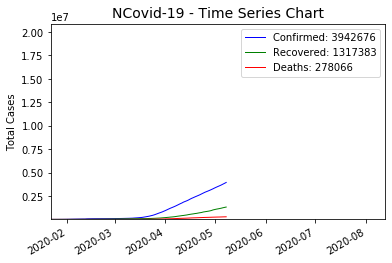

<Figure size 1152x576 with 0 Axes>

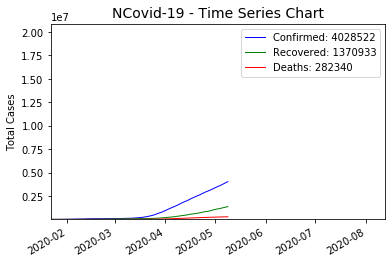

<Figure size 1152x576 with 0 Axes>

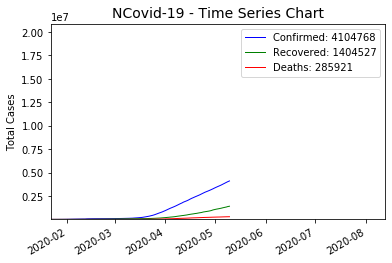

<Figure size 1152x576 with 0 Axes>

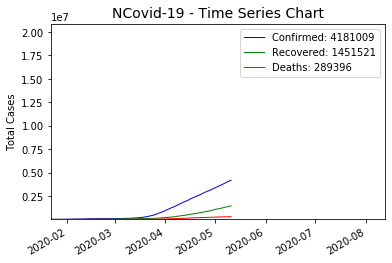

<Figure size 1152x576 with 0 Axes>

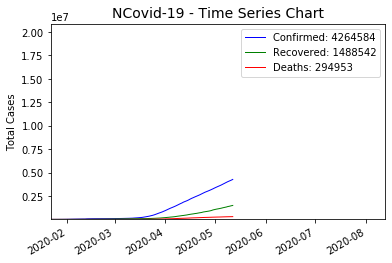

<Figure size 1152x576 with 0 Axes>

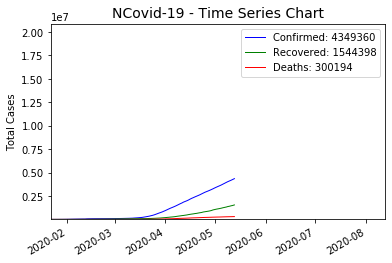

<Figure size 1152x576 with 0 Axes>

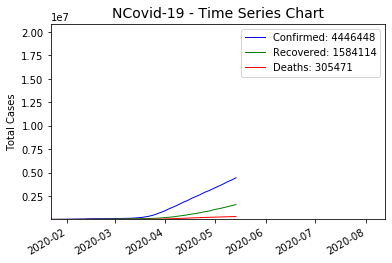

<Figure size 1152x576 with 0 Axes>

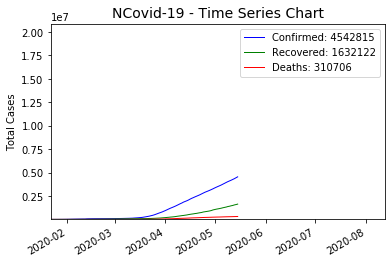

<Figure size 1152x576 with 0 Axes>

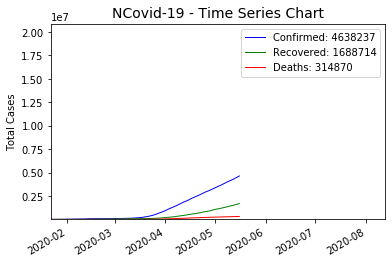

<Figure size 1152x576 with 0 Axes>

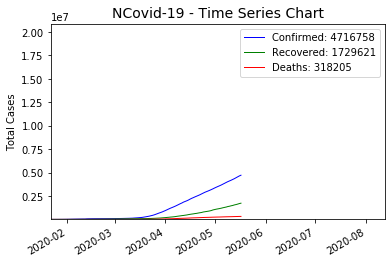

<Figure size 1152x576 with 0 Axes>

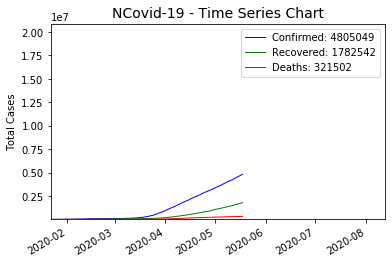

<Figure size 1152x576 with 0 Axes>

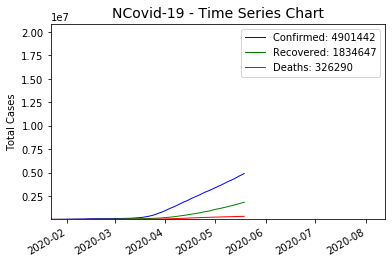

<Figure size 1152x576 with 0 Axes>

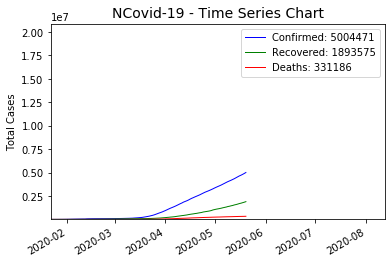

<Figure size 1152x576 with 0 Axes>

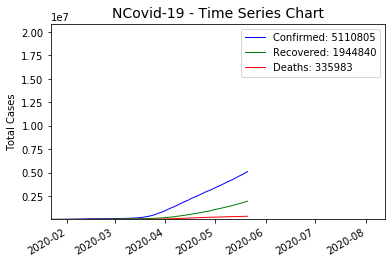

<Figure size 1152x576 with 0 Axes>

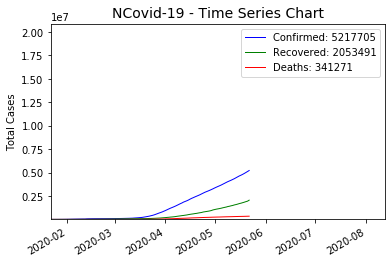

<Figure size 1152x576 with 0 Axes>

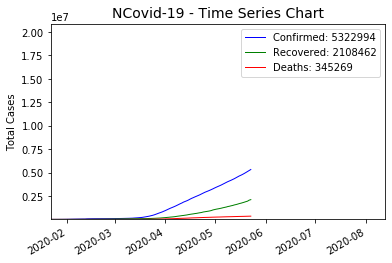

<Figure size 1152x576 with 0 Axes>

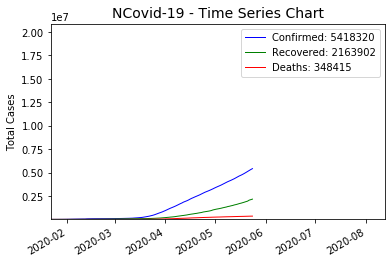

<Figure size 1152x576 with 0 Axes>

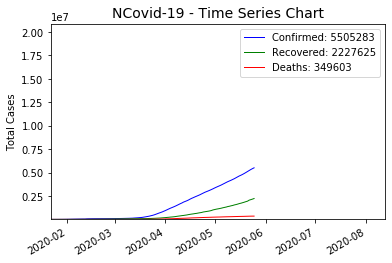

<Figure size 1152x576 with 0 Axes>

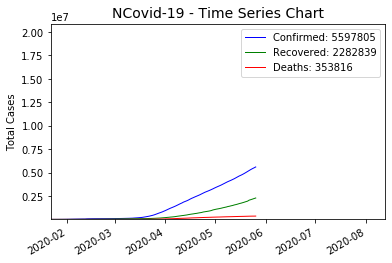

<Figure size 1152x576 with 0 Axes>

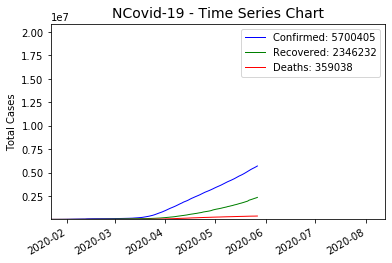

<Figure size 1152x576 with 0 Axes>

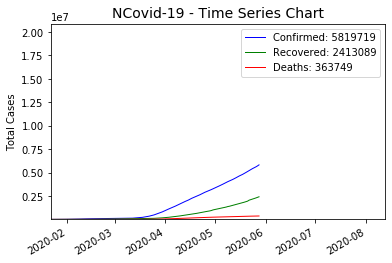

<Figure size 1152x576 with 0 Axes>

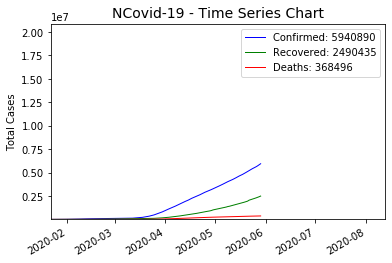

<Figure size 1152x576 with 0 Axes>

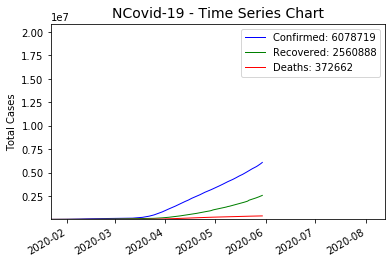

<Figure size 1152x576 with 0 Axes>

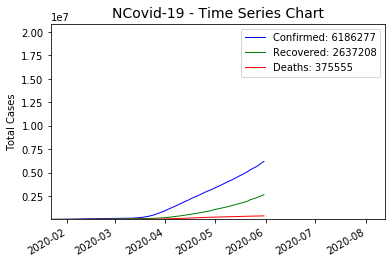

<Figure size 1152x576 with 0 Axes>

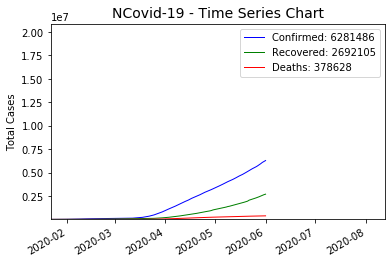

<Figure size 1152x576 with 0 Axes>

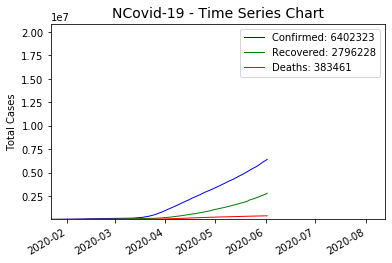

<Figure size 1152x576 with 0 Axes>

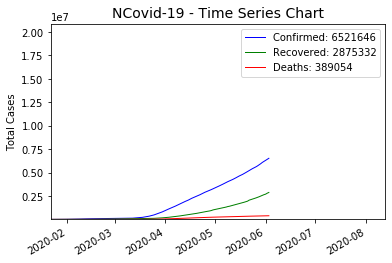

<Figure size 1152x576 with 0 Axes>

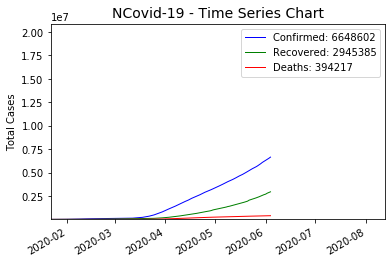

<Figure size 1152x576 with 0 Axes>

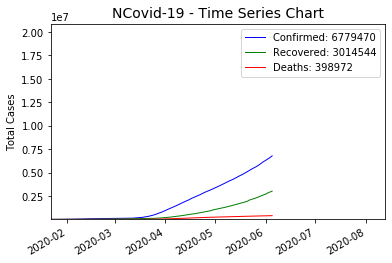

<Figure size 1152x576 with 0 Axes>

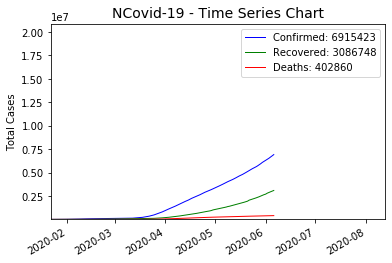

<Figure size 1152x576 with 0 Axes>

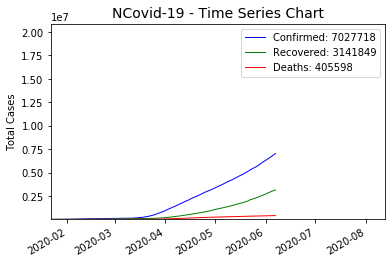

<Figure size 1152x576 with 0 Axes>

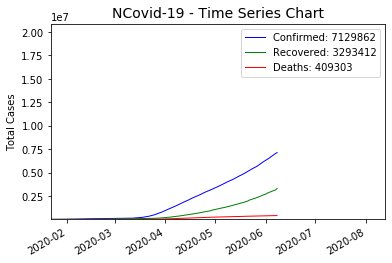

<Figure size 1152x576 with 0 Axes>

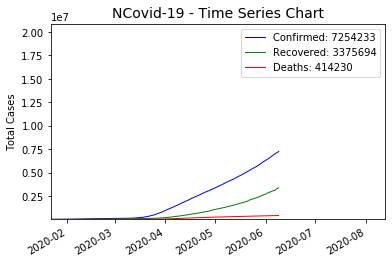

<Figure size 1152x576 with 0 Axes>

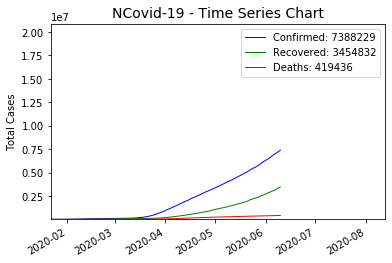

<Figure size 1152x576 with 0 Axes>

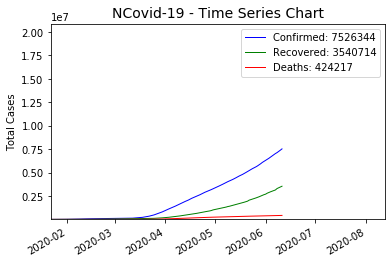

<Figure size 1152x576 with 0 Axes>

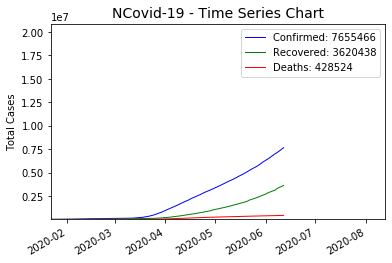

<Figure size 1152x576 with 0 Axes>

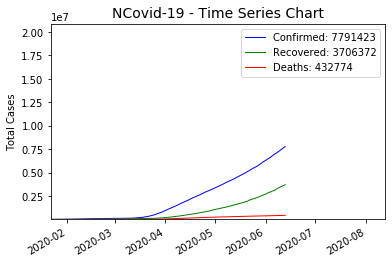

<Figure size 1152x576 with 0 Axes>

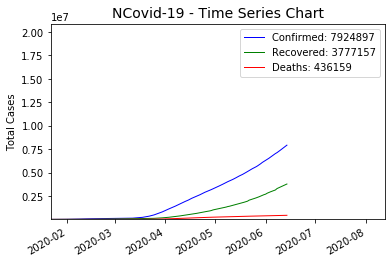

<Figure size 1152x576 with 0 Axes>

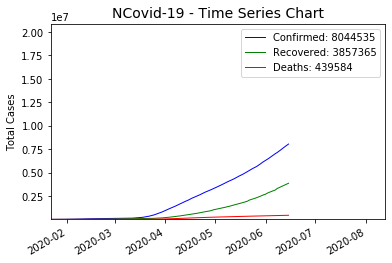

<Figure size 1152x576 with 0 Axes>

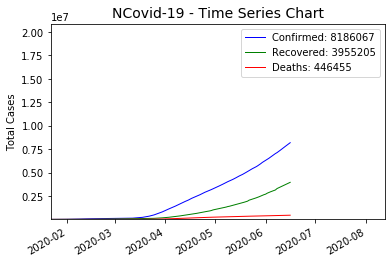

<Figure size 1152x576 with 0 Axes>

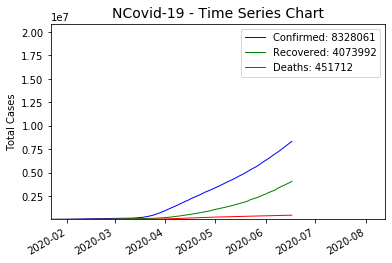

<Figure size 1152x576 with 0 Axes>

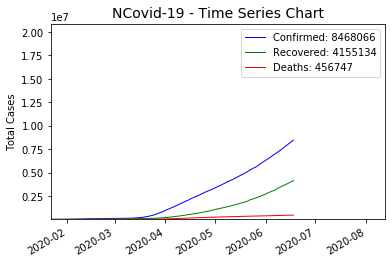

<Figure size 1152x576 with 0 Axes>

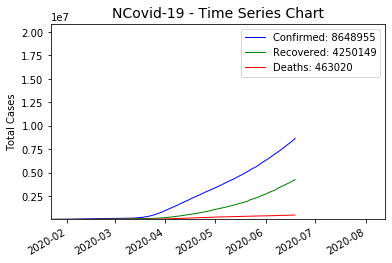

<Figure size 1152x576 with 0 Axes>

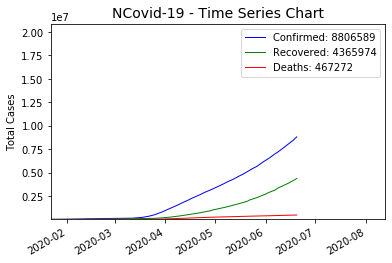

<Figure size 1152x576 with 0 Axes>

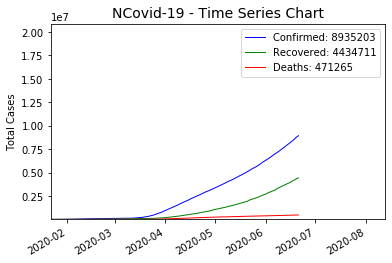

<Figure size 1152x576 with 0 Axes>

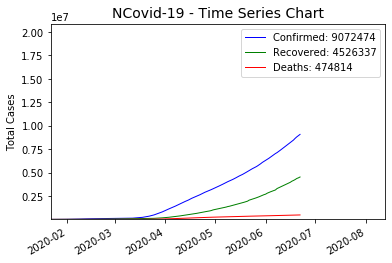

<Figure size 1152x576 with 0 Axes>

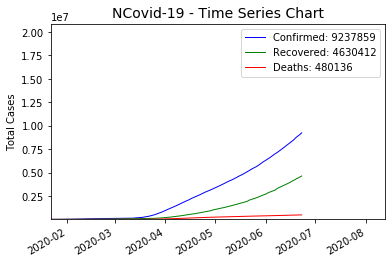

<Figure size 1152x576 with 0 Axes>

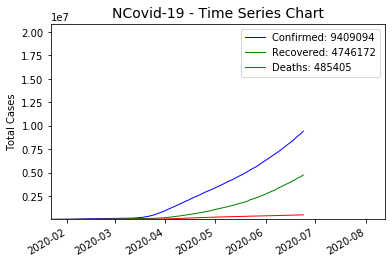

<Figure size 1152x576 with 0 Axes>

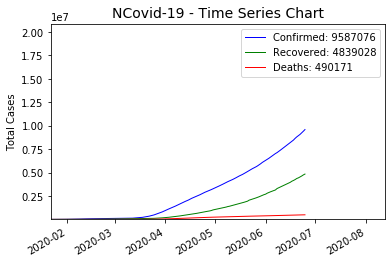

<Figure size 1152x576 with 0 Axes>

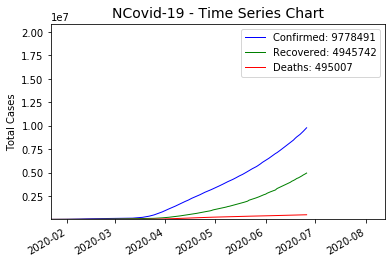

<Figure size 1152x576 with 0 Axes>

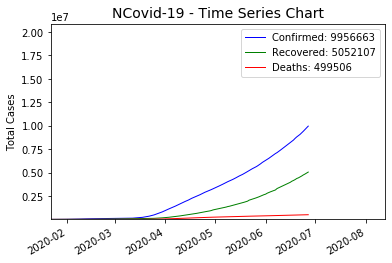

<Figure size 1152x576 with 0 Axes>

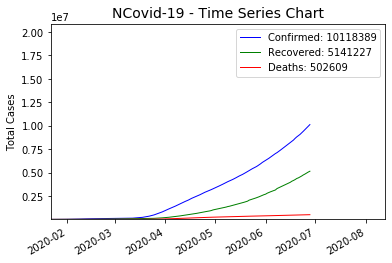

<Figure size 1152x576 with 0 Axes>

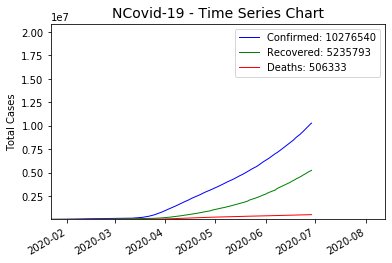

<Figure size 1152x576 with 0 Axes>

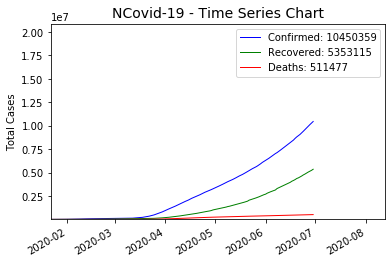

<Figure size 1152x576 with 0 Axes>

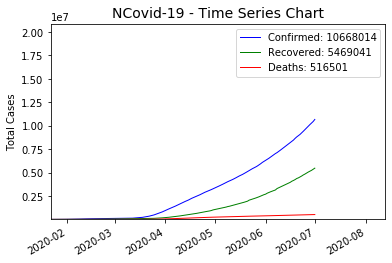

<Figure size 1152x576 with 0 Axes>

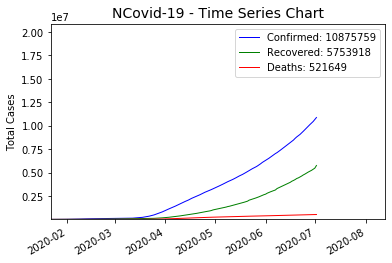

<Figure size 1152x576 with 0 Axes>

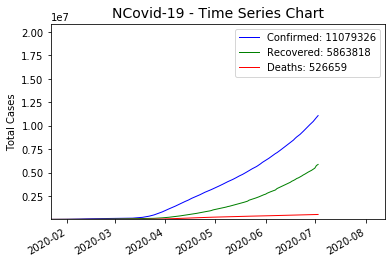

<Figure size 1152x576 with 0 Axes>

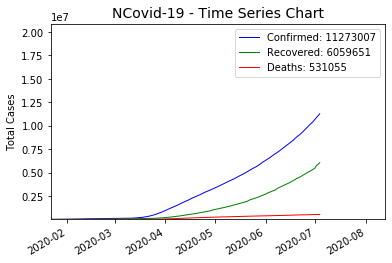

<Figure size 1152x576 with 0 Axes>

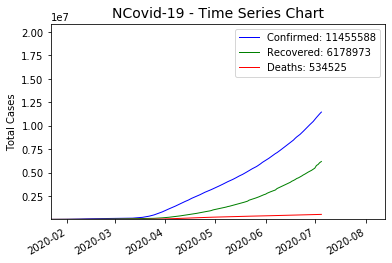

<Figure size 1152x576 with 0 Axes>

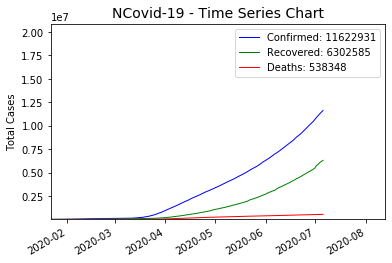

<Figure size 1152x576 with 0 Axes>

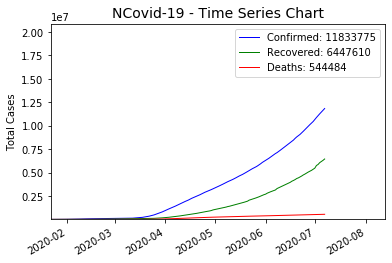

<Figure size 1152x576 with 0 Axes>

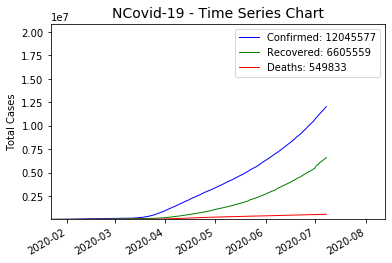

<Figure size 1152x576 with 0 Axes>

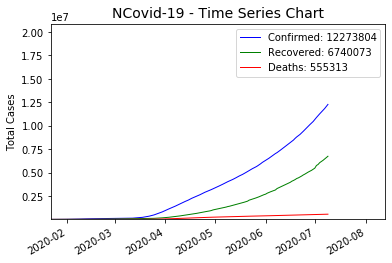

<Figure size 1152x576 with 0 Axes>

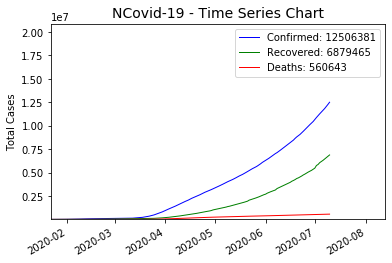

<Figure size 1152x576 with 0 Axes>

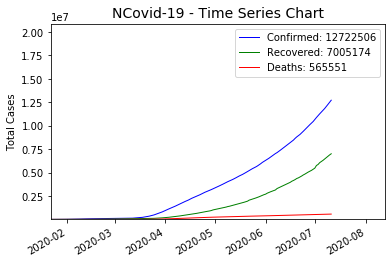

<Figure size 1152x576 with 0 Axes>

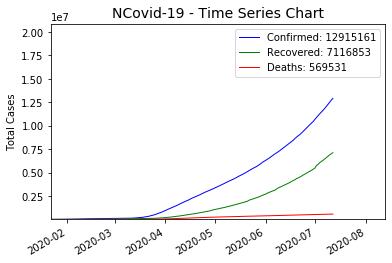

<Figure size 1152x576 with 0 Axes>

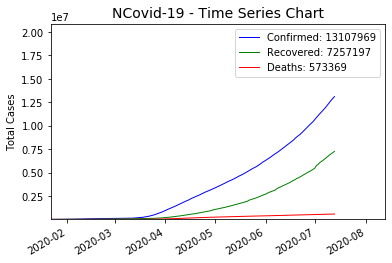

<Figure size 1152x576 with 0 Axes>

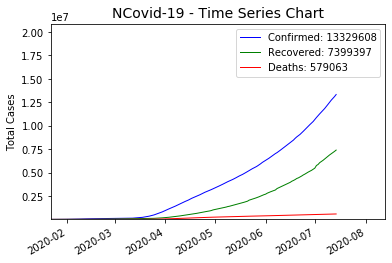

<Figure size 1152x576 with 0 Axes>

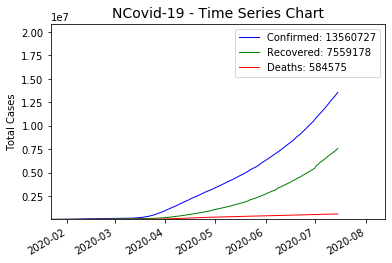

<Figure size 1152x576 with 0 Axes>

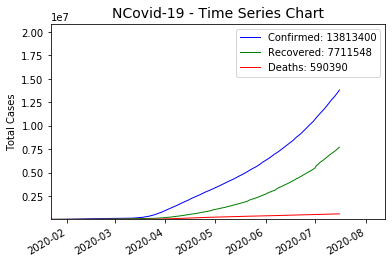

<Figure size 1152x576 with 0 Axes>

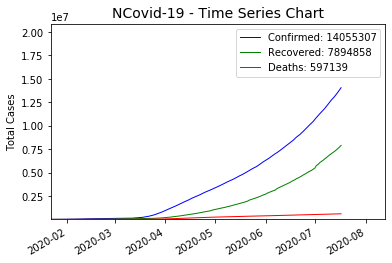

<Figure size 1152x576 with 0 Axes>

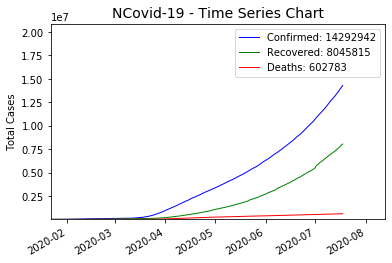

<Figure size 1152x576 with 0 Axes>

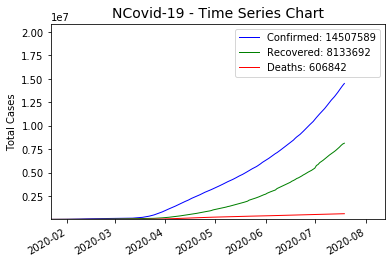

<Figure size 1152x576 with 0 Axes>

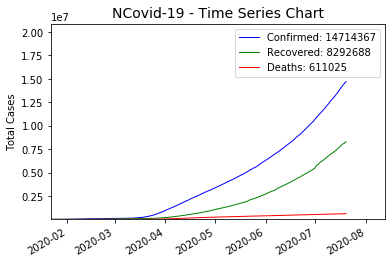

<Figure size 1152x576 with 0 Axes>

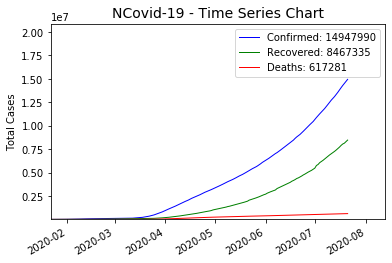

<Figure size 1152x576 with 0 Axes>

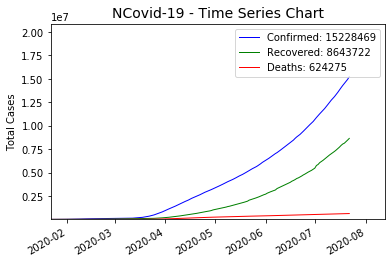

<Figure size 1152x576 with 0 Axes>

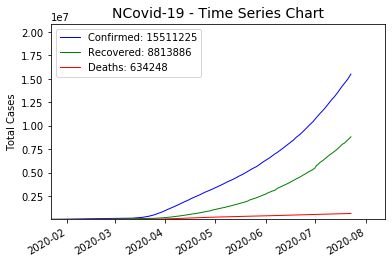

<Figure size 1152x576 with 0 Axes>

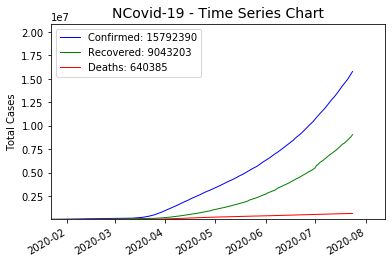

<Figure size 1152x576 with 0 Axes>

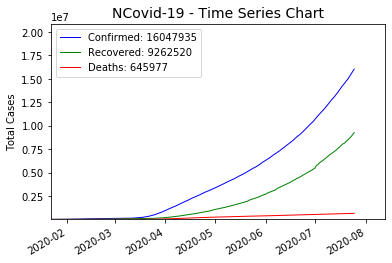

<Figure size 1152x576 with 0 Axes>

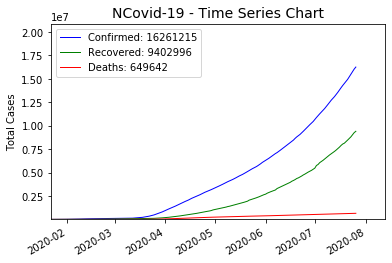

<Figure size 1152x576 with 0 Axes>

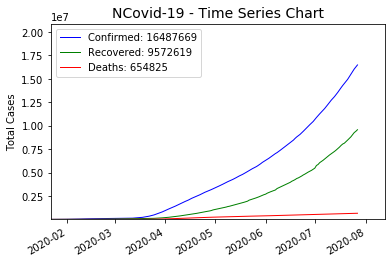

<Figure size 1152x576 with 0 Axes>

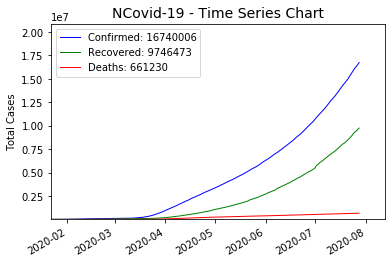

<Figure size 1152x576 with 0 Axes>

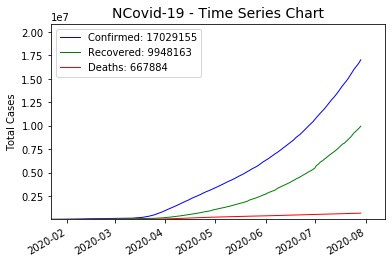

<Figure size 1152x576 with 0 Axes>

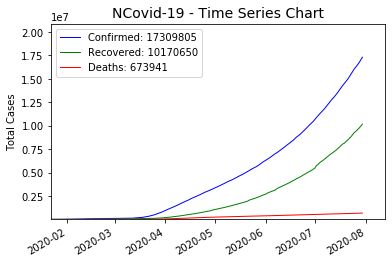

<Figure size 1152x576 with 0 Axes>

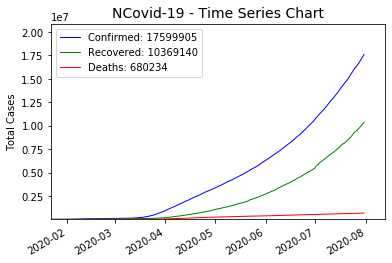

<Figure size 1152x576 with 0 Axes>

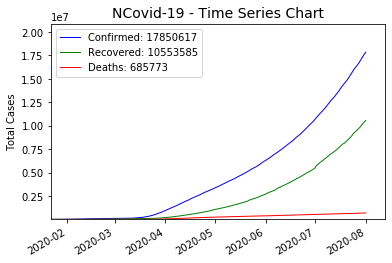

<Figure size 1152x576 with 0 Axes>

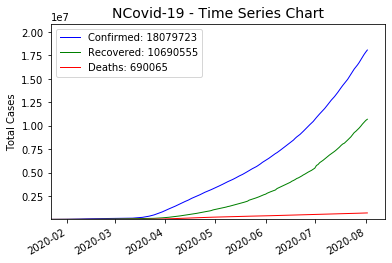

<Figure size 1152x576 with 0 Axes>

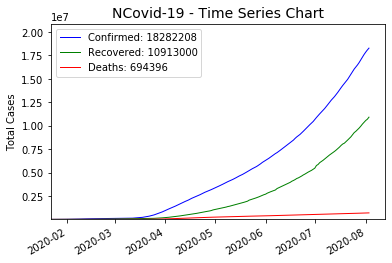

<Figure size 1152x576 with 0 Axes>

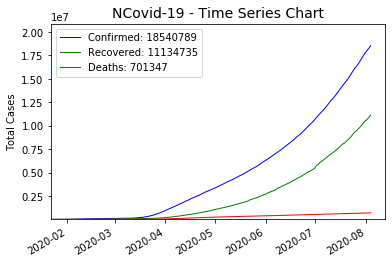

<Figure size 1152x576 with 0 Axes>

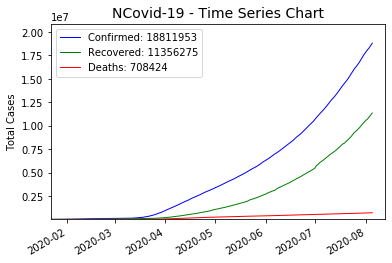

<Figure size 1152x576 with 0 Axes>

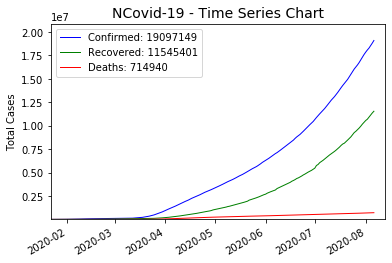

<Figure size 1152x576 with 0 Axes>

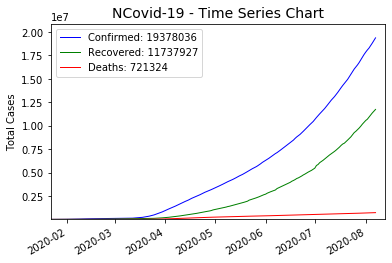

<Figure size 1152x576 with 0 Axes>

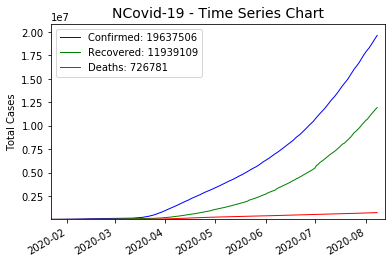

<Figure size 1152x576 with 0 Axes>

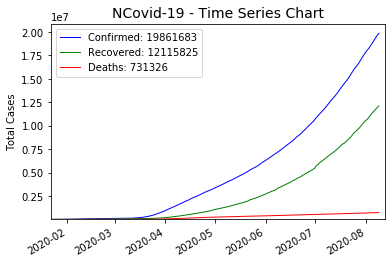

<Figure size 1152x576 with 0 Axes>

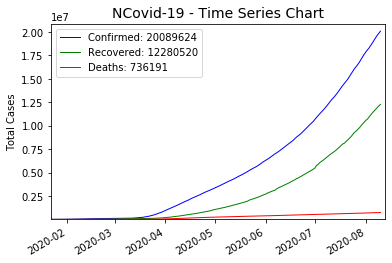

<Figure size 1152x576 with 0 Axes>

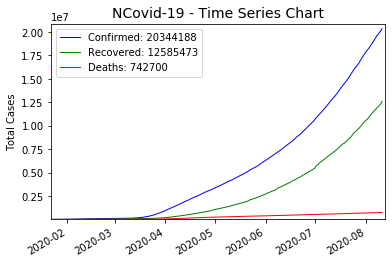

<Figure size 1152x576 with 0 Axes>

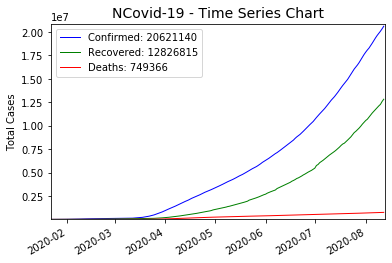

<Figure size 1152x576 with 0 Axes>

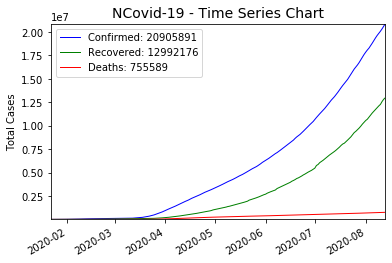

In [16]:
processedImageCount = 0
sortedDates = sorted(list(set(covidDataset['Date'])))\

#Fixing x axis limits
xmin = confirmed.index.min()
xmax = confirmed.index.max()

#Fixing y axis limits
ymin = 0
cmin = confirmed['Confirmed'].min()
rmin = recovered['Recovered'].min()
dmin = deaths['Deaths'].min()

ymin = max([cmin,rmin,dmin])

cmax = confirmed['Confirmed'].max()
rmax = recovered['Recovered'].max()
dmax = deaths['Deaths'].max()

ymax = max([cmax,rmax,dmax])

for date in sortedDates:
    end = str(date).replace(" 00:00:00", "")
    ccount = str(confirmed.loc[end:end, 'Confirmed'].max())
    rcount = str(recovered.loc[end:end, 'Recovered'].max())
    dcount = str(deaths.loc[end:end, 'Deaths'].max())
    
    plt.figure(figsize=(16, 8))

    fig, ax = plt.subplots()
    ax.plot(confirmed.loc[:end, 'Confirmed'], color= 'blue', linestyle='-', linewidth=1, label='Confirmed: '+ccount)
    ax.plot(recovered.loc[:end, 'Recovered'], color= 'green', linestyle='-', linewidth=1, label='Recovered: '+rcount)
    ax.plot(deaths.loc[:end, 'Deaths'], color= 'red', linestyle='-', linewidth=1, label='Deaths: '+dcount)
    fig.autofmt_xdate()
    ax.set_ylabel('Total Cases')
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.legend()
    plt.title('NCovid-19 - Time Series Chart', fontsize = 14)
    imageName = 'animation/liveTimeSeries/ts_' + str(processedImageCount) + '.png'
    imageFilenames.append(imageName)
    plt.savefig(imageName,bbox_inches='tight',pad_inches=0.5)
    processedImageCount +=1


In [36]:
createGif(imageFilenames, 'animation/covidWorldTimeseriesPlot.gif')
print("Plotting of the time series is succesfully completed. Please find the covidWorldTimeseriesPlot.gif inside the 'animation' folder")

Plotting of the time series is succesfully completed. Please find the covidWorldTimeseriesPlot.gif inside the 'animation' folder


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

KeyboardInterrupt: 

<Figure size 2600x1800 with 0 Axes>

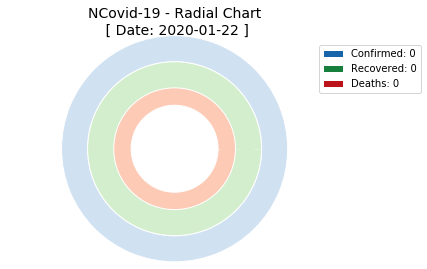

<Figure size 2600x1800 with 0 Axes>

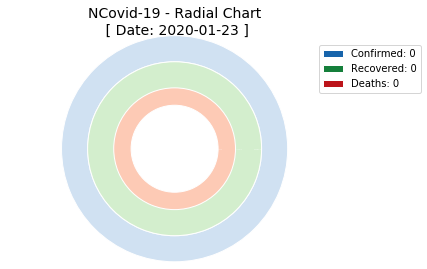

<Figure size 2600x1800 with 0 Axes>

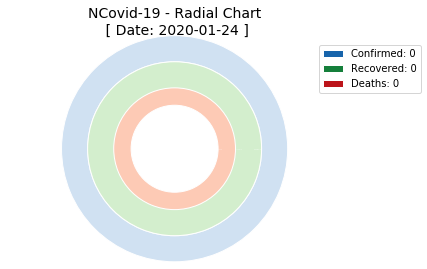

<Figure size 2600x1800 with 0 Axes>

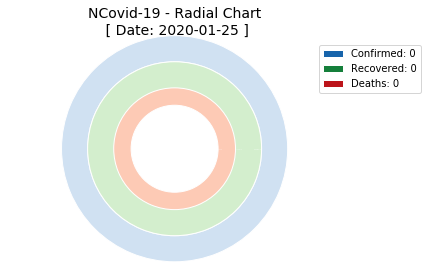

<Figure size 2600x1800 with 0 Axes>

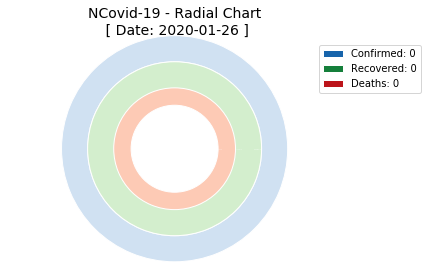

<Figure size 2600x1800 with 0 Axes>

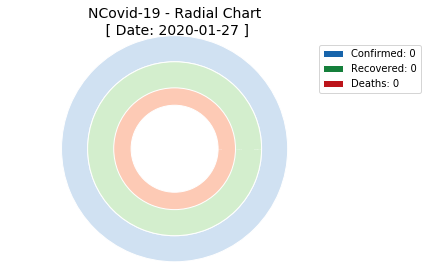

<Figure size 2600x1800 with 0 Axes>

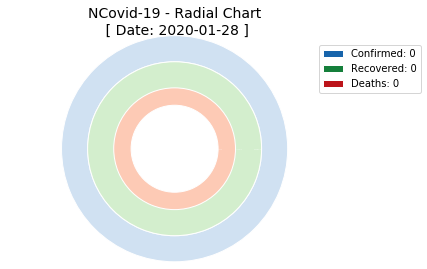

<Figure size 2600x1800 with 0 Axes>

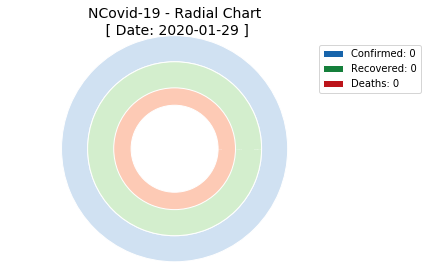

<Figure size 2600x1800 with 0 Axes>

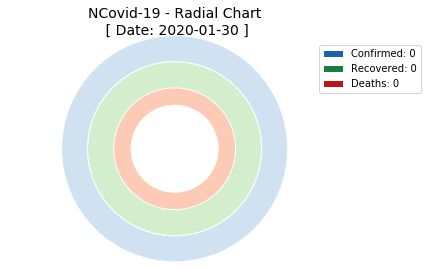

<Figure size 2600x1800 with 0 Axes>

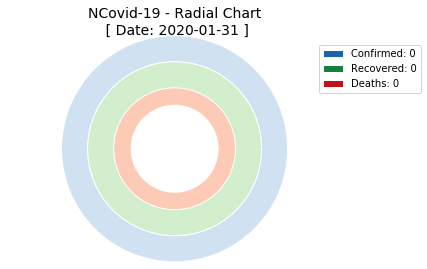

<Figure size 2600x1800 with 0 Axes>

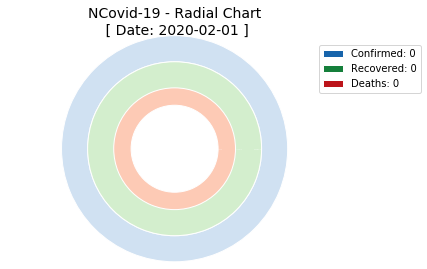

<Figure size 2600x1800 with 0 Axes>

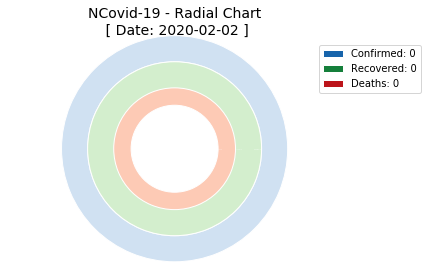

<Figure size 2600x1800 with 0 Axes>

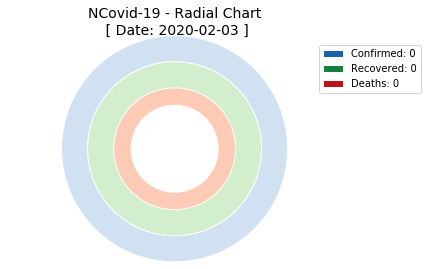

<Figure size 2600x1800 with 0 Axes>

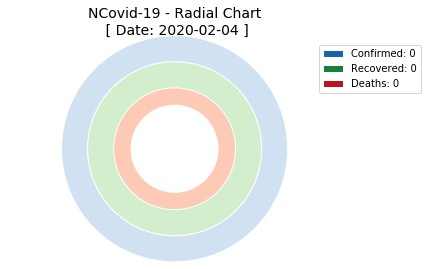

<Figure size 2600x1800 with 0 Axes>

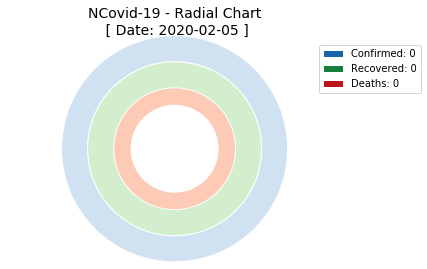

<Figure size 2600x1800 with 0 Axes>

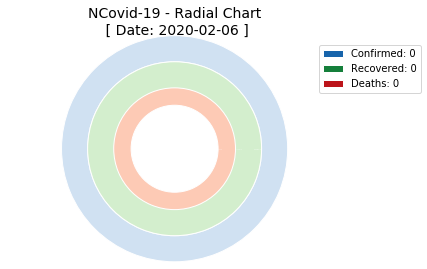

<Figure size 2600x1800 with 0 Axes>

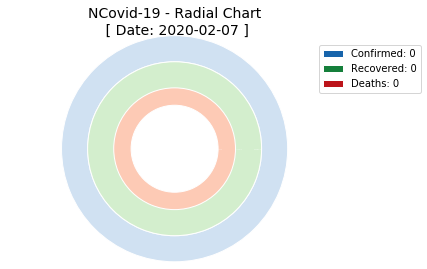

<Figure size 2600x1800 with 0 Axes>

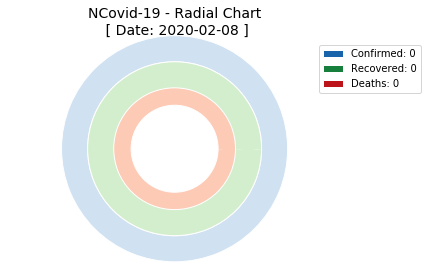

<Figure size 2600x1800 with 0 Axes>

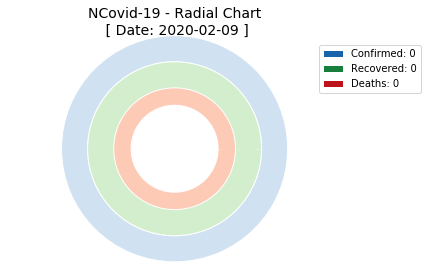

<Figure size 2600x1800 with 0 Axes>

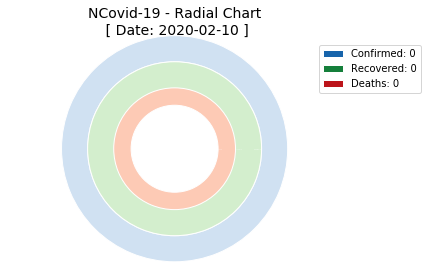

<Figure size 2600x1800 with 0 Axes>

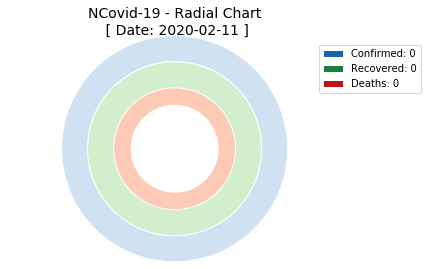

<Figure size 2600x1800 with 0 Axes>

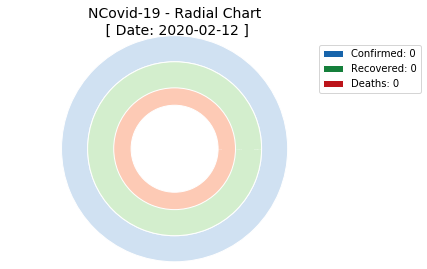

<Figure size 2600x1800 with 0 Axes>

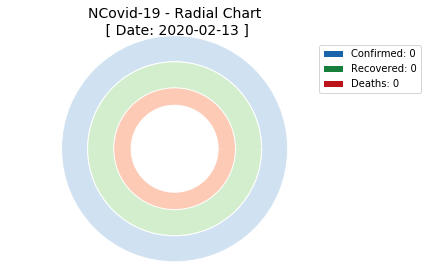

<Figure size 2600x1800 with 0 Axes>

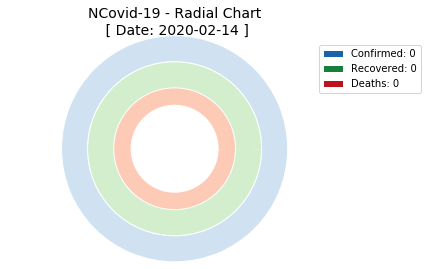

<Figure size 2600x1800 with 0 Axes>

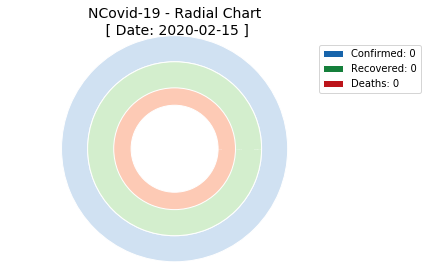

<Figure size 2600x1800 with 0 Axes>

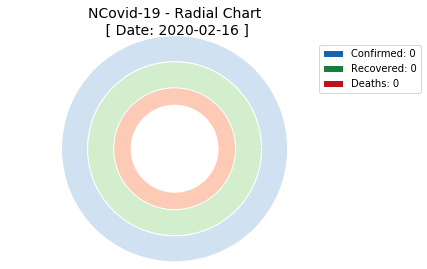

<Figure size 2600x1800 with 0 Axes>

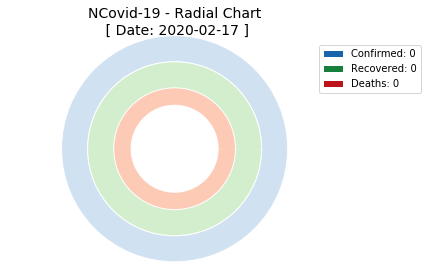

<Figure size 2600x1800 with 0 Axes>

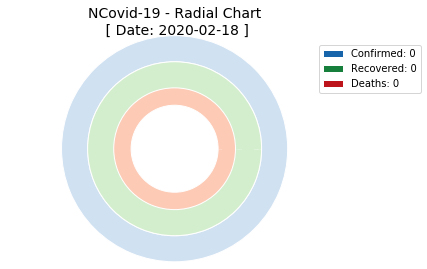

<Figure size 2600x1800 with 0 Axes>

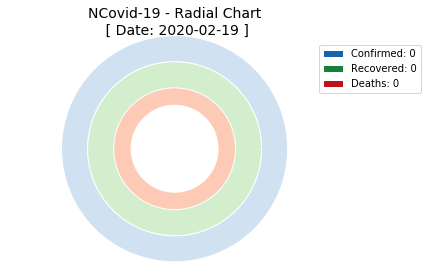

<Figure size 2600x1800 with 0 Axes>

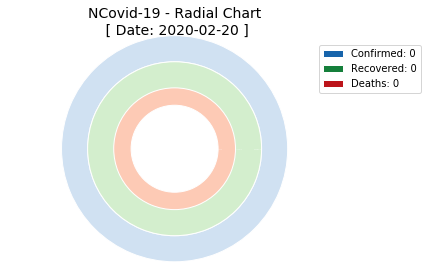

<Figure size 2600x1800 with 0 Axes>

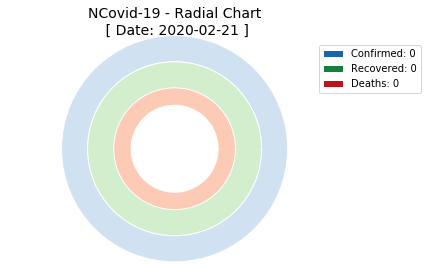

<Figure size 2600x1800 with 0 Axes>

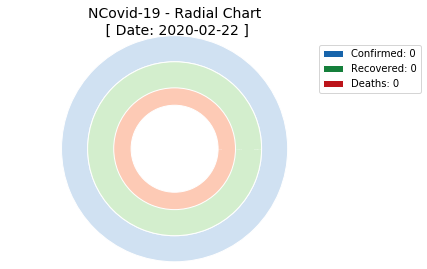

<Figure size 2600x1800 with 0 Axes>

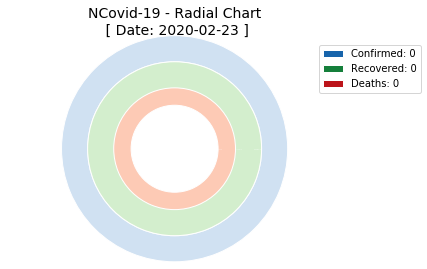

<Figure size 2600x1800 with 0 Axes>

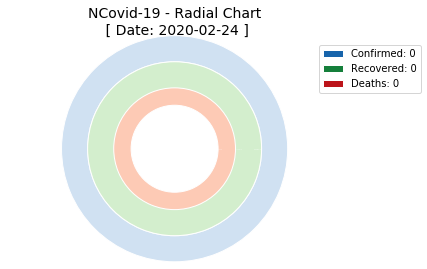

<Figure size 2600x1800 with 0 Axes>

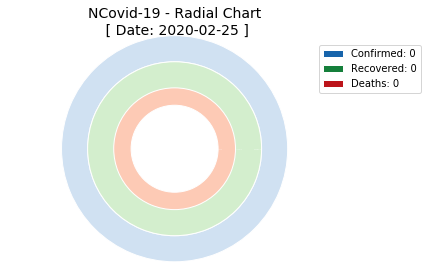

<Figure size 2600x1800 with 0 Axes>

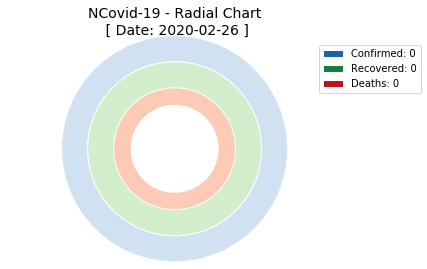

<Figure size 2600x1800 with 0 Axes>

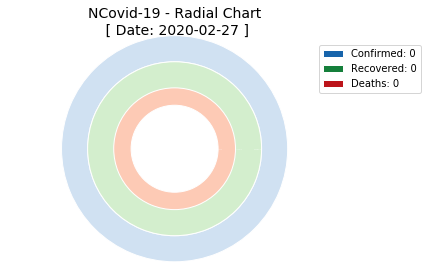

<Figure size 2600x1800 with 0 Axes>

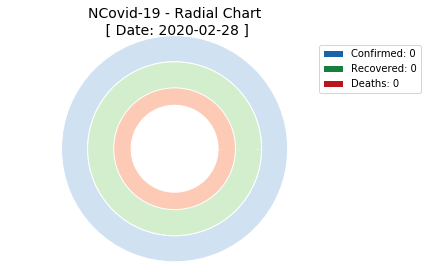

<Figure size 2600x1800 with 0 Axes>

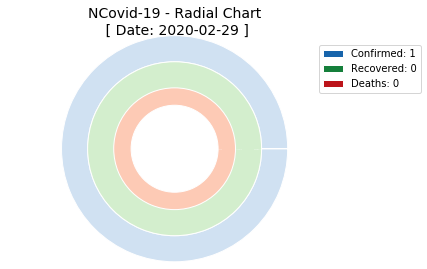

<Figure size 2600x1800 with 0 Axes>

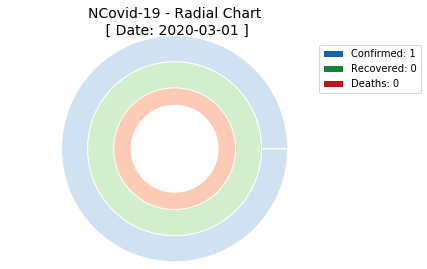

<Figure size 2600x1800 with 0 Axes>

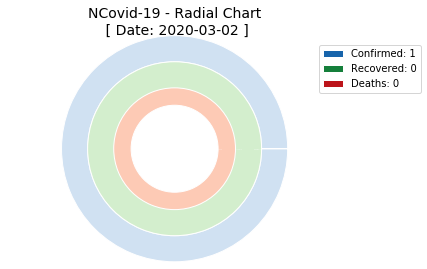

<Figure size 2600x1800 with 0 Axes>

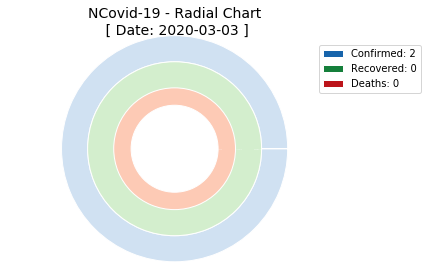

<Figure size 2600x1800 with 0 Axes>

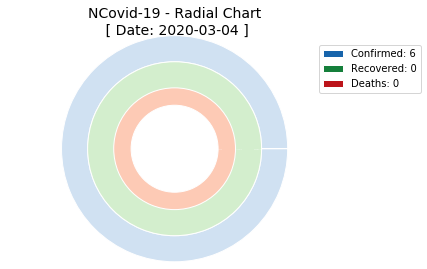

<Figure size 2600x1800 with 0 Axes>

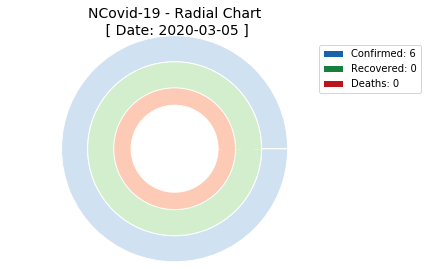

<Figure size 2600x1800 with 0 Axes>

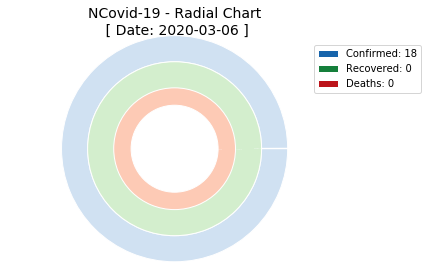

<Figure size 2600x1800 with 0 Axes>

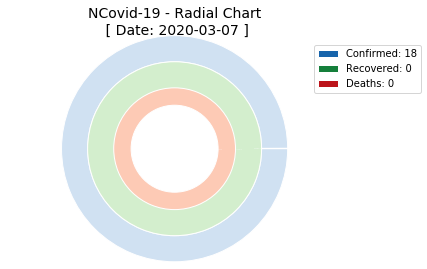

<Figure size 2600x1800 with 0 Axes>

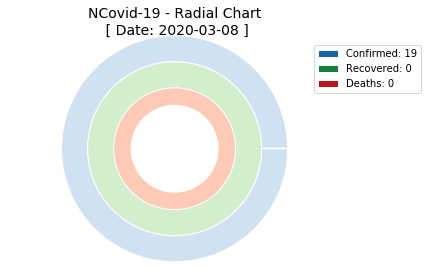

<Figure size 2600x1800 with 0 Axes>

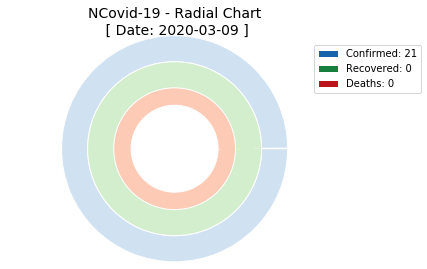

<Figure size 2600x1800 with 0 Axes>

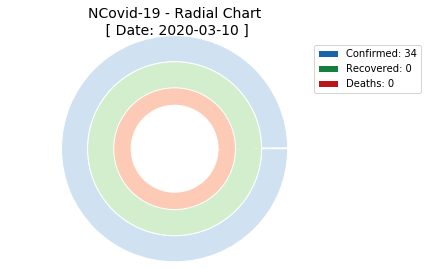

<Figure size 2600x1800 with 0 Axes>

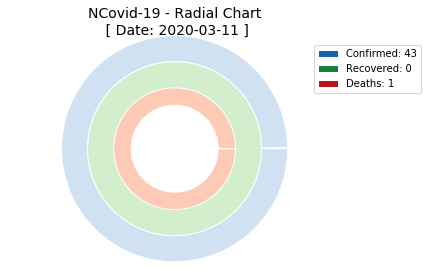

<Figure size 2600x1800 with 0 Axes>

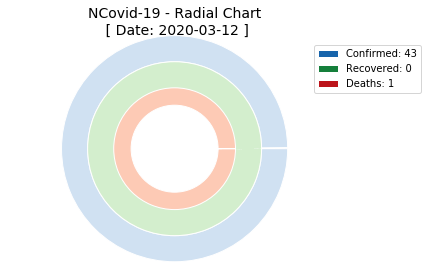

<Figure size 2600x1800 with 0 Axes>

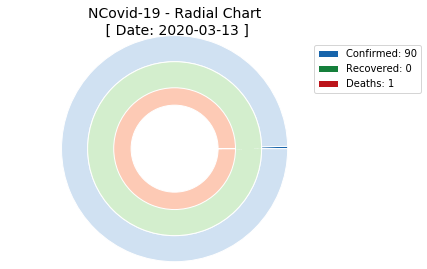

<Figure size 2600x1800 with 0 Axes>

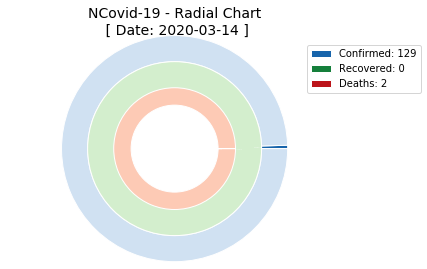

<Figure size 2600x1800 with 0 Axes>

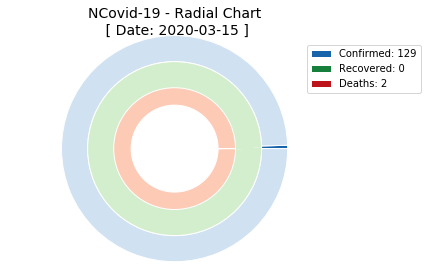

<Figure size 2600x1800 with 0 Axes>

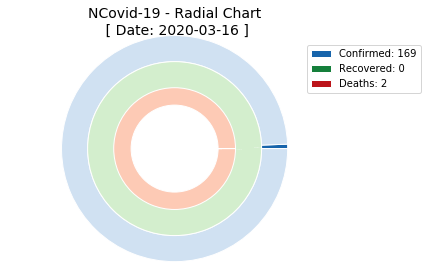

<Figure size 2600x1800 with 0 Axes>

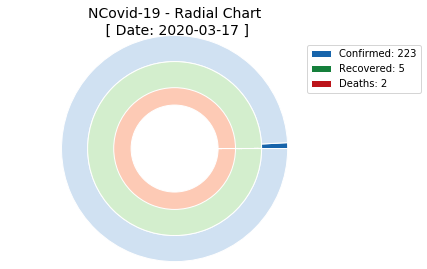

<Figure size 2600x1800 with 0 Axes>

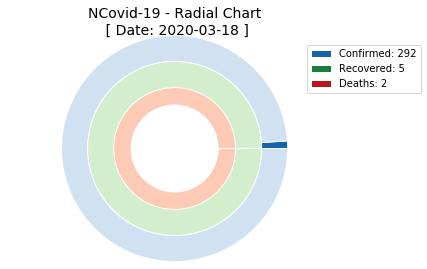

<Figure size 2600x1800 with 0 Axes>

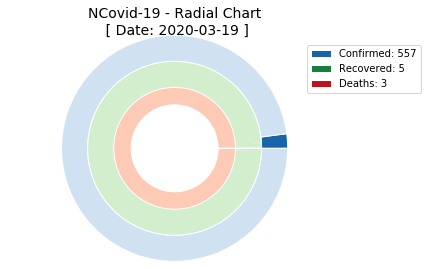

<Figure size 2600x1800 with 0 Axes>

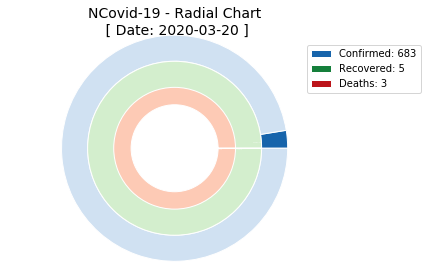

<Figure size 2600x1800 with 0 Axes>

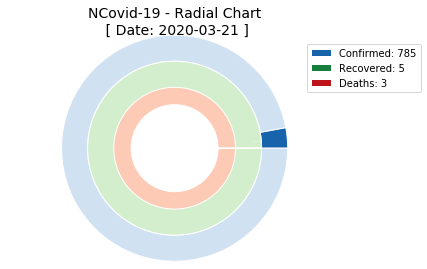

<Figure size 2600x1800 with 0 Axes>

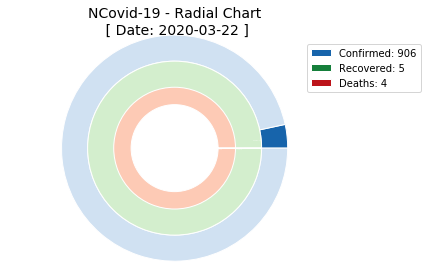

<Figure size 2600x1800 with 0 Axes>

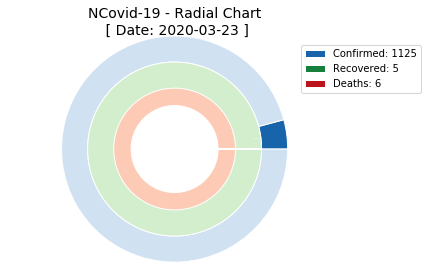

<Figure size 2600x1800 with 0 Axes>

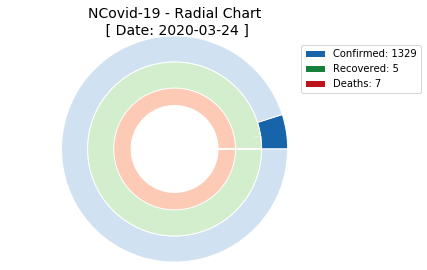

<Figure size 2600x1800 with 0 Axes>

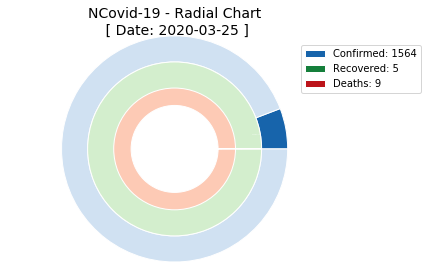

<Figure size 2600x1800 with 0 Axes>

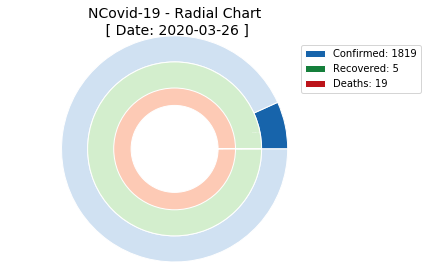

<Figure size 2600x1800 with 0 Axes>

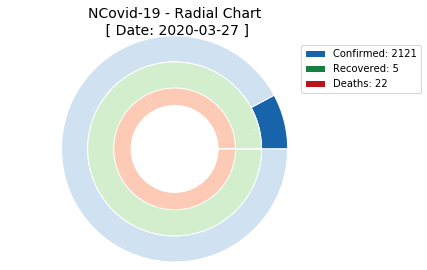

<Figure size 2600x1800 with 0 Axes>

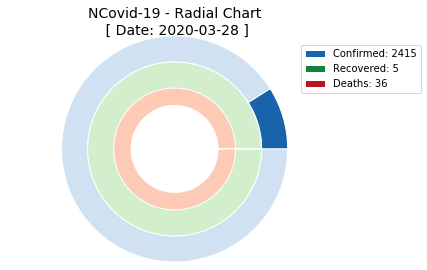

<Figure size 2600x1800 with 0 Axes>

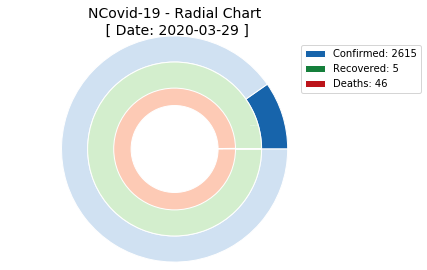

<Figure size 2600x1800 with 0 Axes>

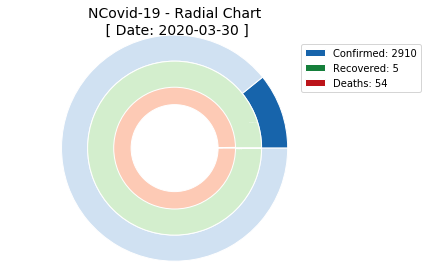

<Figure size 2600x1800 with 0 Axes>

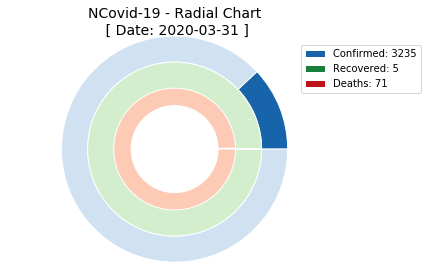

<Figure size 2600x1800 with 0 Axes>

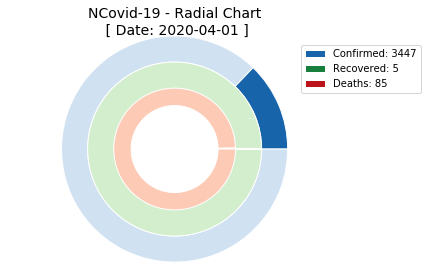

<Figure size 2600x1800 with 0 Axes>

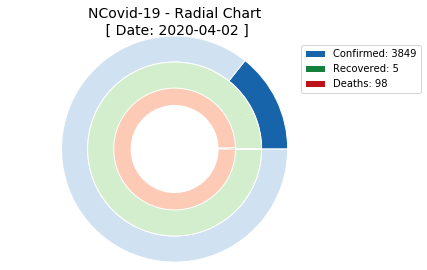

<Figure size 2600x1800 with 0 Axes>

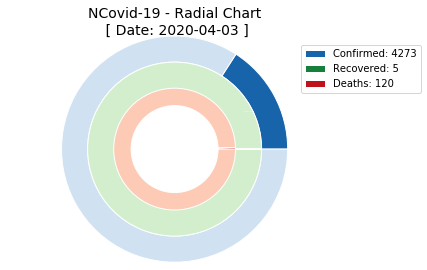

<Figure size 2600x1800 with 0 Axes>

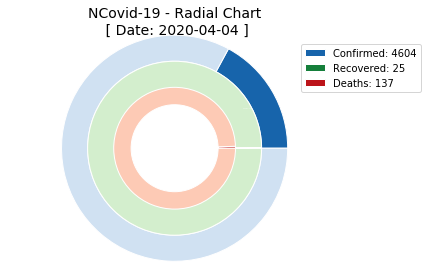

<Figure size 2600x1800 with 0 Axes>

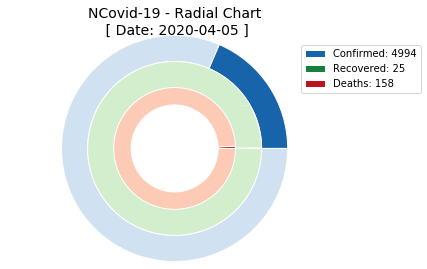

<Figure size 2600x1800 with 0 Axes>

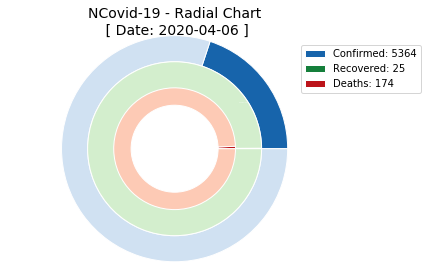

<Figure size 2600x1800 with 0 Axes>

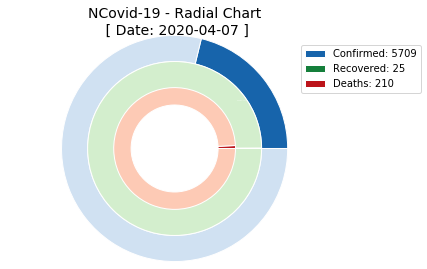

<Figure size 2600x1800 with 0 Axes>

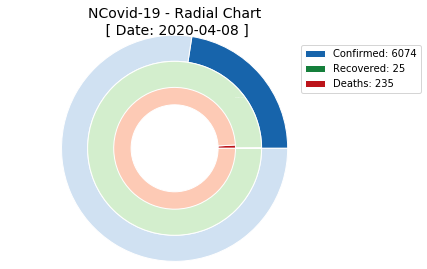

<Figure size 2600x1800 with 0 Axes>

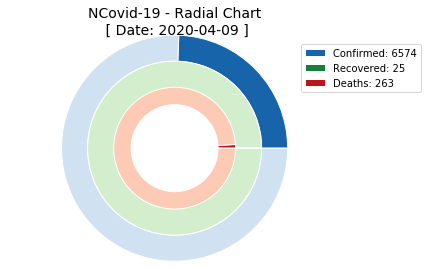

<Figure size 2600x1800 with 0 Axes>

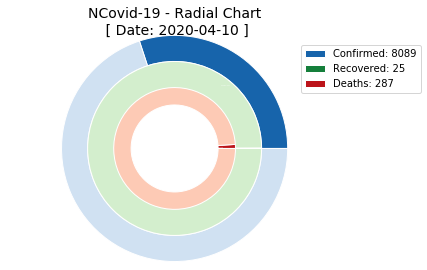

<Figure size 2600x1800 with 0 Axes>

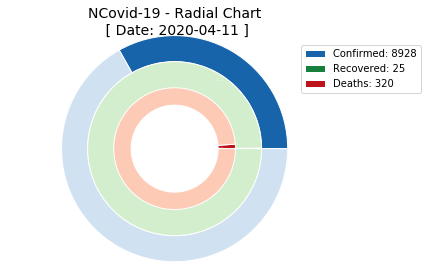

<Figure size 2600x1800 with 0 Axes>

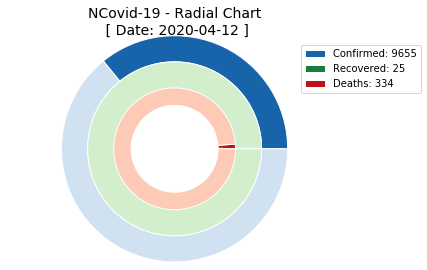

<Figure size 2600x1800 with 0 Axes>

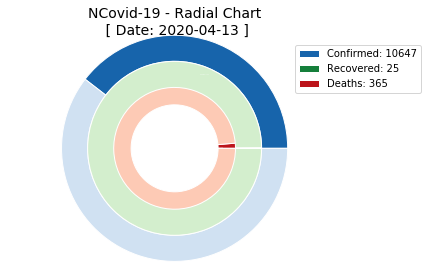

<Figure size 2600x1800 with 0 Axes>

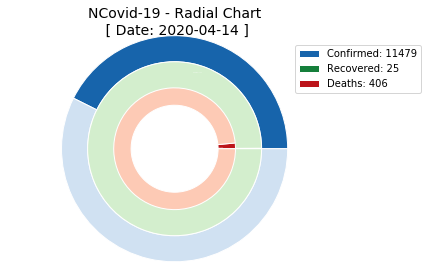

<Figure size 2600x1800 with 0 Axes>

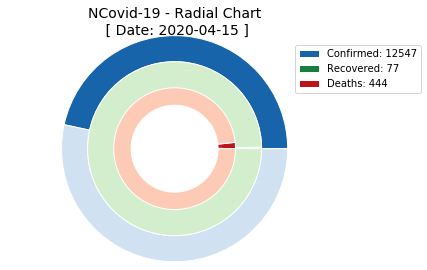

<Figure size 2600x1800 with 0 Axes>

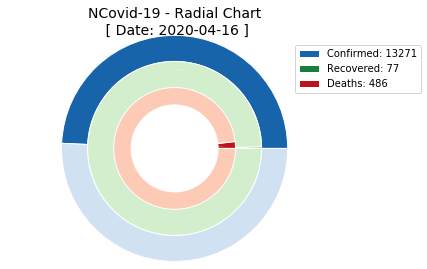

<Figure size 2600x1800 with 0 Axes>

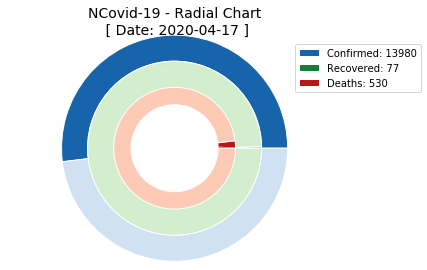

<Figure size 2600x1800 with 0 Axes>

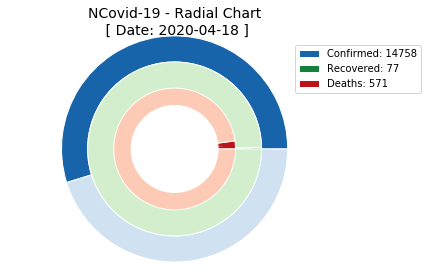

<Figure size 2600x1800 with 0 Axes>

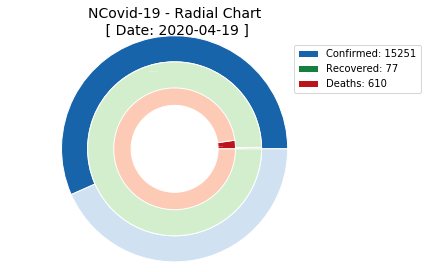

<Figure size 2600x1800 with 0 Axes>

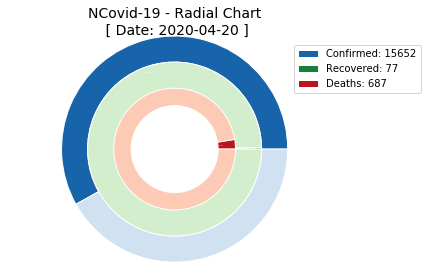

<Figure size 2600x1800 with 0 Axes>

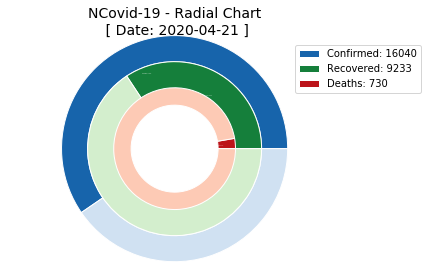

<Figure size 2600x1800 with 0 Axes>

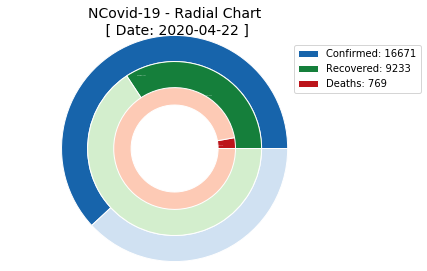

<Figure size 2600x1800 with 0 Axes>

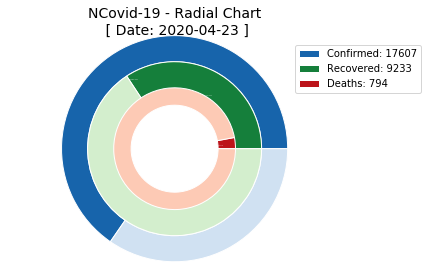

<Figure size 2600x1800 with 0 Axes>

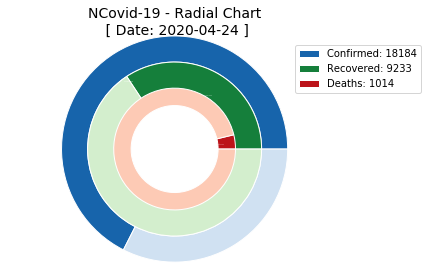

<Figure size 2600x1800 with 0 Axes>

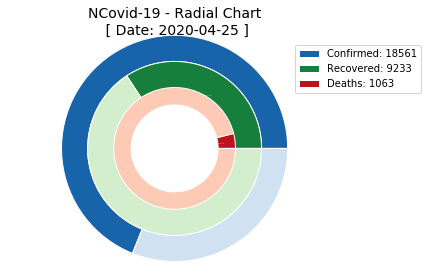

<Figure size 2600x1800 with 0 Axes>

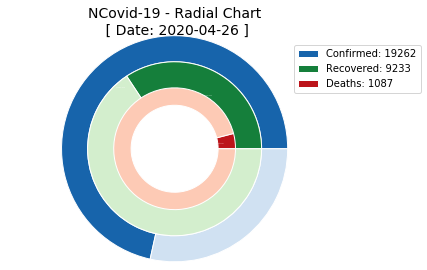

<Figure size 2600x1800 with 0 Axes>

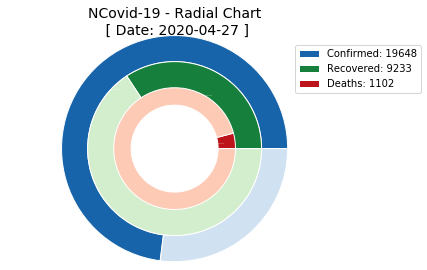

<Figure size 2600x1800 with 0 Axes>

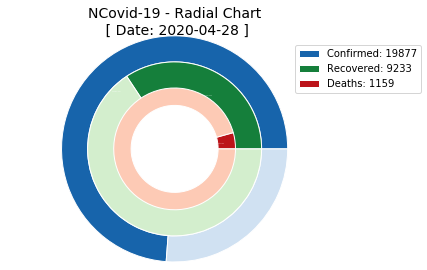

<Figure size 2600x1800 with 0 Axes>

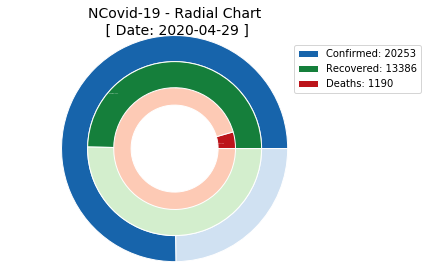

<Figure size 2600x1800 with 0 Axes>

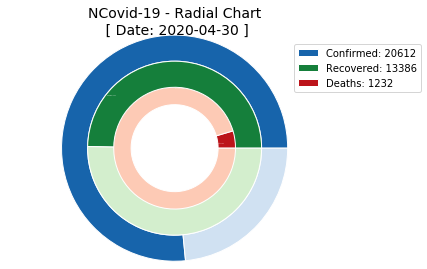

<Figure size 2600x1800 with 0 Axes>

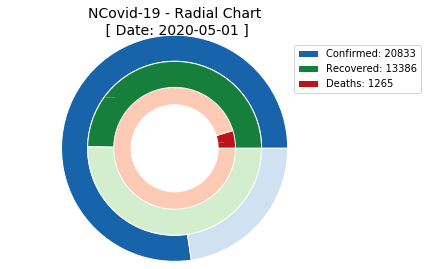

<Figure size 2600x1800 with 0 Axes>

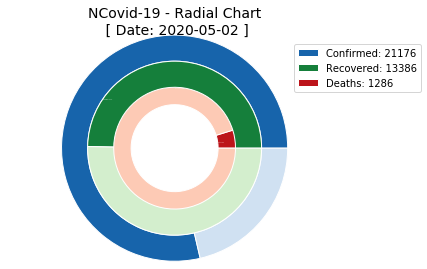

<Figure size 2600x1800 with 0 Axes>

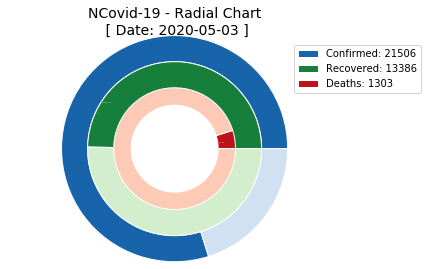

<Figure size 2600x1800 with 0 Axes>

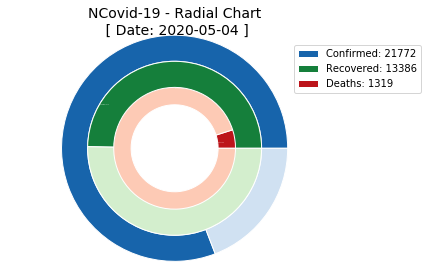

<Figure size 2600x1800 with 0 Axes>

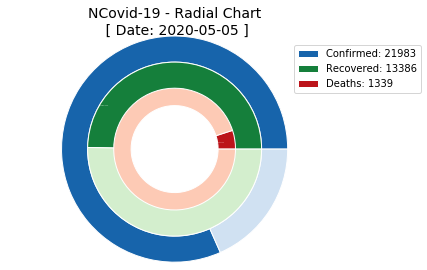

<Figure size 2600x1800 with 0 Axes>

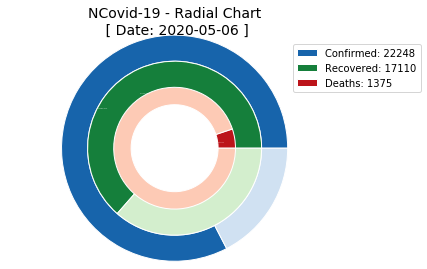

<Figure size 2600x1800 with 0 Axes>

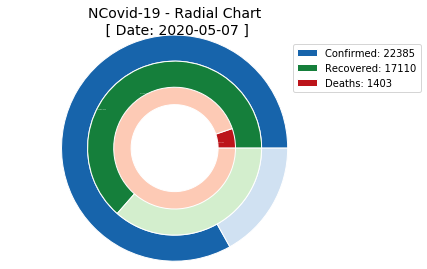

<Figure size 2600x1800 with 0 Axes>

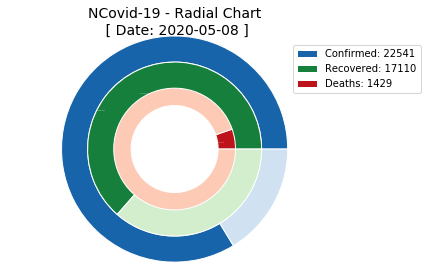

In [39]:
## Plotting radial chart
# Create copy of original dataset
radialChartDataset = covidDataset.set_index('Date')
sortedDates = sorted(list(set(covidDataset['Date'])))

# List of countries for radial chart plotting
countryNames = ['Ireland','India']

# Iterating through list of counrty names for plotting
for country in countryNames:
    processedImageCount = 0
    imageFilenames = []
    countryData = radialChartDataset.loc[radialChartDataset['Country'] == country]
    covidRecord = countryData[['Confirmed','Recovered','Deaths']]
    confirmedMax = covidRecord['Confirmed'].max()
    for date in sortedDates:
        currDate = str(date).replace(' 00:00:00', '')
        # Plotting on radial chart
        dim = 96
        plt.figure(figsize=(2600/dim,1800/dim), dpi=dim)
        fig,ax=plt.subplots()
        ax.axis('equal')
               
        confirmedValue = covidRecord.loc[currDate:currDate, 'Confirmed']
        confirmedPieValue = [confirmedValue, confirmedMax - confirmedValue]
        recoveredValue = covidRecord.loc[currDate:currDate, 'Recovered']
        recoveredPieValue = [recoveredValue, confirmedMax - recoveredValue]
        deathsValue = covidRecord.loc[currDate:currDate, 'Deaths']
        deathsPieValue = [deathsValue, confirmedMax - deathsValue]
        
        confirmedLabel = ['Confirmed: ' + str(confirmedValue.max()), '']
        recoveredLabel = ['Recovered: ' + str(recoveredValue.max()), '']
        deathsLabel = ['Deaths: ' + str(deathsValue.max()), '']
        
        confirmedPieColor, recoveredPieColor, deathPieColor = [plt.cm.Blues, plt.cm.Greens, plt.cm.Reds]
        confirmedPie,_ = ax.pie(confirmedPieValue, radius = 1.3, labeldistance= 0.7, colors = [confirmedPieColor(0.8), confirmedPieColor(0.2)], labels =confirmedLabel, textprops={'color':'white','fontsize':0})
        plt.setp(confirmedPie,width=0.3,edgecolor='white')        
        recoveredPie,_ = ax.pie(recoveredPieValue, radius = 1.3-0.3, labeldistance= 0.7, colors = [recoveredPieColor(0.8), recoveredPieColor(0.2)], labels =recoveredLabel, textprops={'color':'white','fontsize':0})
        plt.setp(recoveredPie,width=0.4,edgecolor='white')        
        deathsPie,_ = ax.pie(deathsPieValue, radius = 1-0.3, labeldistance= 0.7, colors = [deathPieColor(0.8), deathPieColor(0.2)], labels =deathsLabel, textprops={'color':'white','fontsize':0})
        plt.setp(deathsPie,width=0.2,edgecolor='white')
        
        ax.legend(loc='upper right', bbox_to_anchor= (0.75,0.5,0.5,0.5))
        
        plt.margins(0,0)
        plt.title('NCovid-19 - Radial Chart\n [ Date: '+ currDate + ' ]', fontsize = 14)
        imageName = 'animation/liveRadial/rc_' + str(processedImageCount) + '.png'
        imageFilenames.append(imageName)
        plt.savefig(imageName,bbox_inches='tight',pad_inches=0.5)
        processedImageCount +=1
        
    createGif(imageFilenames, 'animation/covidRadialPlot.gif')
    print("Plotting of the radial graph is succesfully completed. Please find the covidRadialPlot.gif inside the 'animation' folder")
        

Plotting of the radial graph is succesfully completed. Please find the covidRadialPlot.gif inside the 'animation' folder
